# Vision Language Model Evaluation

This notebook evaluates multiple vision language models (e.g., LLaVA-NeXT, GPT-5o and Qwen3-VL) on three systematically constructed image datasets designed to probe color-concept representations: canonical object colors, counterfactual recolorings and abstract colored shapes.


In [1]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration,
    AutoProcessor,
    AutoModelForVision2Seq
)
import torch
import pandas as pd
import gc
import numpy as np
from tqdm import tqdm
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import re

ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from test_MLLMs import run_vlm_evaluation, ask_vlm_introspection_threshold
from making_color_images.plot_variants import (plot_vlm_prolific,
                                            plot_fg_response_frequencies_line,
                                            plot_fg_response_frequencies_bar,
                                            plot_bg_response_frequencies_bar,
                                            plot_bg_response_frequencies_line,
                                            plot_model_logprobs,)

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

In [ ]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda


15914

In [4]:
# Load the datasets that where also used in the human evaluation
prior_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_image_priors_prolific.csv")
counterfact_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_counterfact_prolific.csv")
shape_df = pd.read_csv(DATA / "prolific_stimuli" / f"stimulus_table_shapes_prolific.csv")

def norm_image_paths(df):
    df = df.copy()
    df["image_path"] = df["image_path"].apply(
    lambda p: str(DATA / p)
    )
    return df

prior_df = norm_image_paths(prior_df)
counterfact_df = norm_image_paths(counterfact_df)
shape_df = norm_image_paths(shape_df)

display(prior_df.head(), prior_df.shape, counterfact_df.head(), counterfact_df.shape, shape_df.head(), shape_df.shape)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,correct_prior,brown,brown,FG,100,FG 100% (seq),seq


(1260, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,counterfact,red,red,FG,20,FG 20% (seq),seq


(412, 9)

,image_path,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,shape,orange,orange,FG,90,FG 90% (seq),seq


(1331, 9)

In [5]:
def evaluate_vlm_on_stimuli_old(
    df_stimuli: pd.DataFrame,
    *,
    processor=None,
    model=None,
    device,
    image_root: Path,
    backend: str = "llava",      # "llava" | "qwen" | "gpt4" | "gpt52"
    model_name: str | None = None,
    batch_size: int = 1,
    mode: str = "this",
    calibration_value: int | None = None,
    desc: str = "Evaluating stimuli",
):
    """
    Evaluate a VLM on a set of stimulus images.

    Expects df_stimuli to have columns:
      - image_path (relative to image_root)
      - object
      - target_color
    """

    preds = []

    for _, row in tqdm(
        df_stimuli.iterrows(),
        total=len(df_stimuli),
        desc=desc,
    ):
        df_eval_input = pd.DataFrame({
            "image_path": [image_root / row["image_path"]],
            "object": [row["object"]],
            "correct_answer": [row["target_color"]],
        })

        # --- run backend-specific evaluation ---
        df_eval = run_vlm_evaluation(
            df=df_eval_input,
            processor=processor,
            model=model,
            device=device,
            backend=backend,
            model_name=model_name,
            mode=mode,
            calibration_value=calibration_value,
        )
        # keep only stable columns
        cols = [
            "object",
            "image_path",
            "correct_answer",
            "pred_color_this",
            "prob_correct_this"
            ""
        ]

        #print(df_eval)

        # optional: log calibration
        if calibration_value is not None:
            df_eval["calibration_threshold"] = calibration_value
            cols.append("calibration_threshold")

        preds.append(df_eval[cols])

        # memory hygiene for torch models
        if backend in ["llava", "qwen"]:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

    return pd.concat(preds, ignore_index=True)


In [6]:
def evaluate_vlm_on_stimuli(
    df_stimuli: pd.DataFrame,
    *,
    processor=None,
    model=None,
    device,
    image_root: Path,
    backend: str = "llava",      # "llava" | "qwen" | "gpt4" | "gpt52"
    model_name: str | None = None,
    batch_size: int = 1,
    mode: str = "this",
    calibration_value: int | None = None,
    desc: str = "Evaluating stimuli",
):
    """
    Evaluate a VLM on a set of stimulus images.

    Expects df_stimuli to have columns:
      - image_path (relative)
      - object
      - target_color
    """

    outputs = []

    for _, row in tqdm(
        df_stimuli.iterrows(),
        total=len(df_stimuli),
        desc=desc,
    ):

        # --- Build single-row eval input ---
        df_eval_input = pd.DataFrame({
            "image_path": [image_root / row["image_path"]],
            "object": [row["object"]],
            "correct_answer": [row["target_color"]],
        })

        # --- Run backend-specific evaluation ---
        df_eval = run_vlm_evaluation(
            df=df_eval_input,
            processor=processor,
            model=model,
            device=device,
            backend=backend,
            model_name=model_name,
            mode=mode,
            calibration_value=calibration_value,
        )

        if df_eval is None or len(df_eval) == 0:
            raise ValueError("Model returned empty dataframe.")

        # --- Normalize column names (GPT vs others) ---
        if "pred_color_this" in df_eval.columns:
            df_eval = df_eval.rename(
                columns={"pred_color_this": "predicted_color"}
            )

        # --- Required columns check ---
        required = {"object", "image_path", "correct_answer", "predicted_color"}
        missing = required - set(df_eval.columns)
        if missing:
            raise ValueError(
                f"Missing required columns in model output: {missing}"
            )

        # --- Add calibration threshold if provided ---
        if calibration_value is not None:
            df_eval["calibration_threshold"] = calibration_value

        outputs.append(df_eval)

        # --- GPU memory hygiene ---
        if backend in ["llava", "qwen"]:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

    if len(outputs) == 0:
        return pd.DataFrame()

    return pd.concat(outputs, ignore_index=True)

In [7]:
VALID_COLORS = {
    "white", "brown", "grey", "green",
    "red", "blue", "orange",
    "yellow", "pink", "purple",
    "black"
}

def normalize_color_prediction(raw):

    if raw is None:
        return None

    raw = raw.lower().strip()

    # remove punctuation except hyphen
    raw = re.sub(r"[^\w\s-]", "", raw)

    # normalize hyphen to space
    raw = raw.replace("-", " ")

    tokens = raw.split()

    # --- special case: black and white ---
    if "black" in tokens and "white" in tokens:
        return "white"

    # --- direct single-color match ---
    if len(tokens) == 1 and tokens[0] in VALID_COLORS:
        return tokens[0]

    # --- first valid canonical color in phrase ---
    for tok in tokens:
        if tok in VALID_COLORS:
            return tok

    return "other"

# 1. LLaVA-NeXT

In [76]:
llava_model_name = "llava-v1.6-mistral-7b-hf"
llava_processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
llava_model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

LLAVA = DATA / "LLaVA-NeXT_results"
LLAVA.mkdir(parents=True, exist_ok=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1.1. Introspection question (LLaVA-NeXT)

In [78]:
calibration = ask_vlm_introspection_threshold(
    backend="llava",
    processor=llava_processor,
    model=llava_model,
    device=device,
    model_name=llava_model_name,
)

llava_threshold = calibration["introspection_threshold"]
print(llava_threshold)

[INST]  
For any object, x% of its pixels should be colored for it to be considered that color.
For example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
At what point would you personally say that the banana in the image is yellow?
What value should x% be?
Please only answer with a single number between 0 and 100.
[/INST] 50 
50


## 1.2.1 Color Prior Dataset (LLaVA-NeXT)

In [ ]:
suffix = "image_priors"
llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [17:34<00:00,  1.20it/s]

                                             image_path          object  \
0     /mnt/lustre/work/eickhoff/esx061/color-concept...          cheese   
1     /mnt/lustre/work/eickhoff/esx061/color-concept...  espresso maker   
2     /mnt/lustre/work/eickhoff/esx061/color-concept...       tile roof   
3     /mnt/lustre/work/eickhoff/esx061/color-concept...           cloud   
4     /mnt/lustre/work/eickhoff/esx061/color-concept...  frilled lizard   
...                                                 ...             ...   
1255  /mnt/lustre/work/eickhoff/esx061/color-concept...        eggplant   
1256  /mnt/lustre/work/eickhoff/esx061/color-concept...     rattlesnake   
1257  /mnt/lustre/work/eickhoff/esx061/color-concept...       tow truck   
1258  /mnt/lustre/work/eickhoff/esx061/color-concept...           snake   
1259  /mnt/lustre/work/eickhoff/esx061/color-concept...      rottweiler   

     correct_answer predicted_color logprob_pred_token logprob_correct_token  \
0             white

,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.256501,-10.654939,False,NaN,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,-1.101001,-12.749438,False,NaN,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.028346,-11.536159,False,NaN,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.142373,-14.216591,False,NaN,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.161806,-10.232119,False,NaN,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.119483,-9.025734,False,NaN,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.459060,-12.091872,False,NaN,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.095186,-10.251436,False,NaN,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.058242,-11.409804,False,NaN,correct_prior,green,green,FG,50,FG 50% (seq),seq


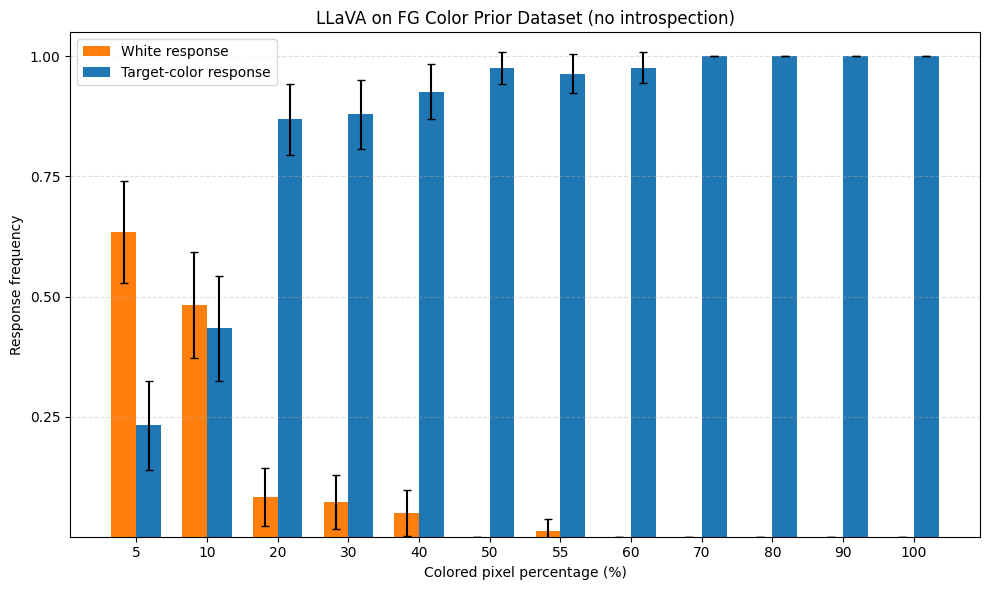

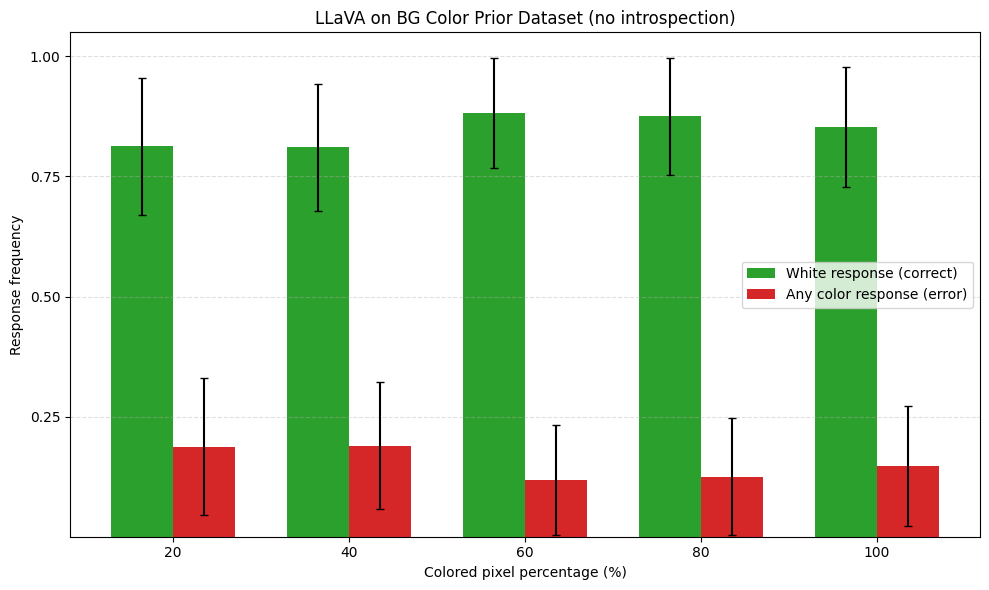

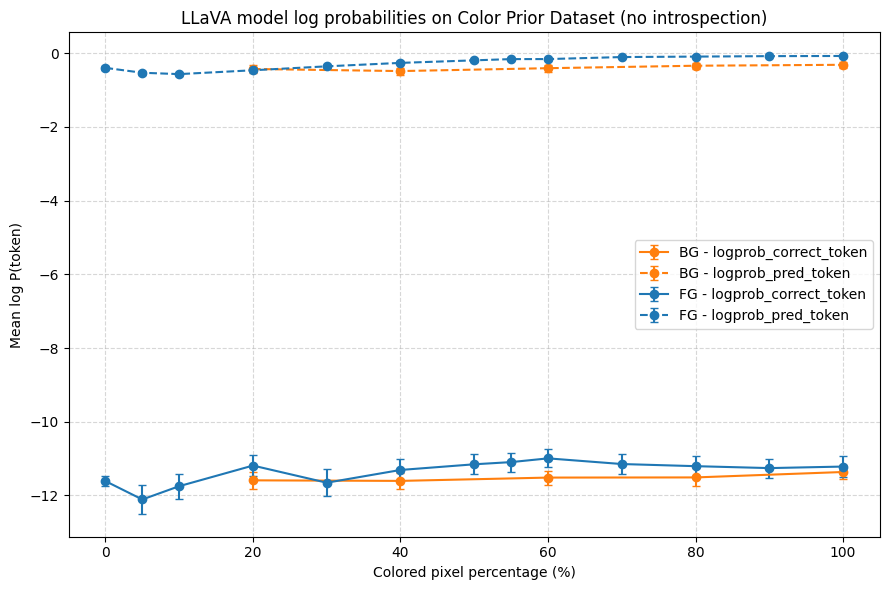

In [15]:
llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_image_priors.csv")
llava_prior_pred_df["predicted_color"] = llava_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
llava_prior_pred_df = llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(llava_prior_pred_df)

plot_fg_response_frequencies_bar(llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (no introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (no introspection)", response_col="predicted_color")

plot_model_logprobs(
    llava_prior_pred_df,
    title="LLaVA model log probabilities on Color Prior Dataset (no introspection)",
)

## 1.2.2 Color Prior Dataset with Introspection Question (LLaVA-NeXT)

In [11]:
suffix = "image_priors"
introsp_llava_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    calibration_value=llava_threshold,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [17:37<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.520403,-11.028215,False,50,50,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-1.085430,-11.108868,False,50,50,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.038748,-11.218436,False,50,50,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.184376,-13.801563,False,50,50,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.220732,-10.244170,False,50,50,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.162086,-8.810523,False,50,50,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.550447,-12.089509,False,50,50,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.116080,-9.928580,False,50,50,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.078677,-11.320865,False,50,50,correct_prior,green,green,FG,50,FG 50% (seq),seq


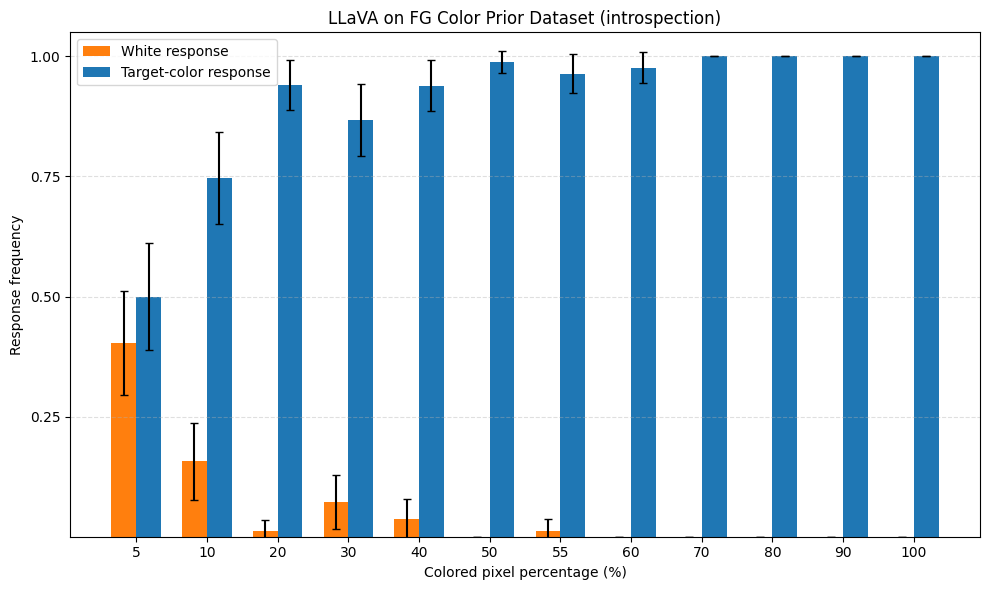

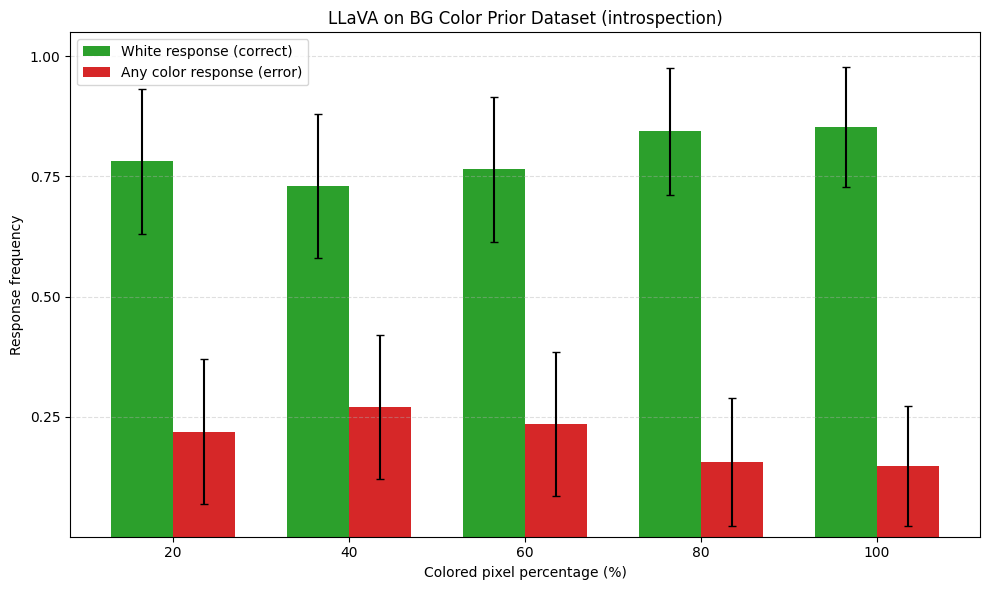

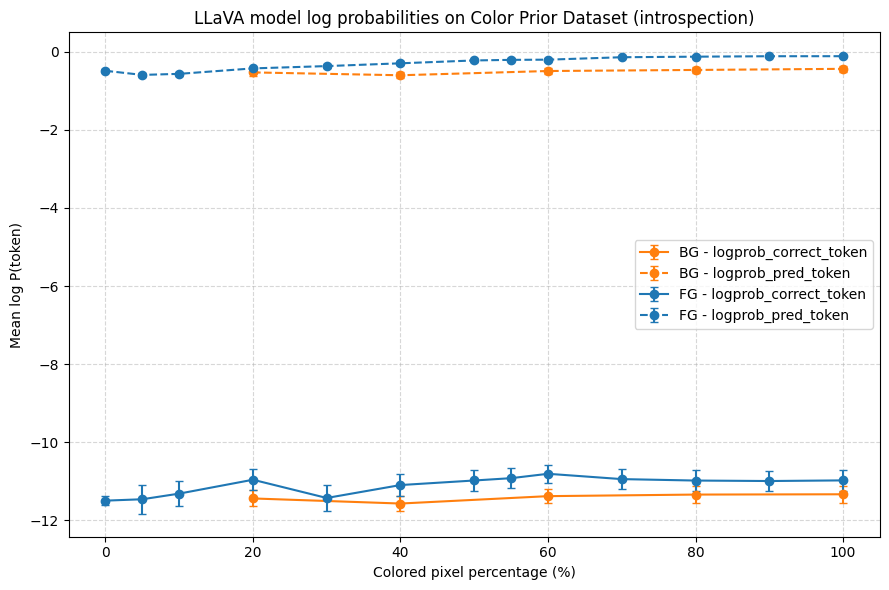

In [16]:
introsp_llava_prior_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_image_priors.csv")
introsp_llava_prior_pred_df["predicted_color"] = introsp_llava_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_llava_prior_pred_df = introsp_llava_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_llava_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_llava_prior_pred_df, title="LLaVA on FG Color Prior Dataset (introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(introsp_llava_prior_pred_df, title="LLaVA on BG Color Prior Dataset (introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_llava_prior_pred_df,
    title="LLaVA model log probabilities on Color Prior Dataset (introspection)",
)

## 1.3.1. Counterfact Color Dataset (LLaVA-NeXT)

In [12]:
suffix = "counterfact"
llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_cf_pred_df.to_csv(out_path, index=False)

Evaluating counterfact object colors (counterfact stimuli): 100%|██████████| 412/412 [05:47<00:00,  1.18it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.008931,-10.633931,False,NaN,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.038745,-9.694995,False,NaN,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.298155,-10.704405,False,NaN,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.289183,-11.664184,False,NaN,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.551923,-12.075361,False,NaN,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.134755,-10.869130,False,NaN,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.947944,-10.635445,False,NaN,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.333490,-9.778803,False,NaN,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.052415,-11.278977,False,NaN,counterfact,green,green,FG,70,FG 70% (seq),seq


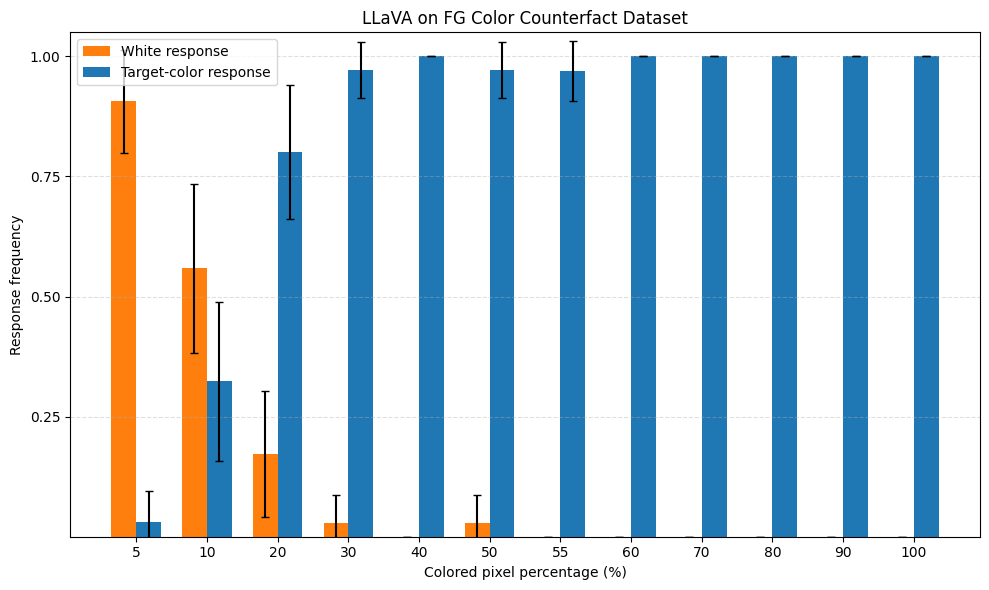

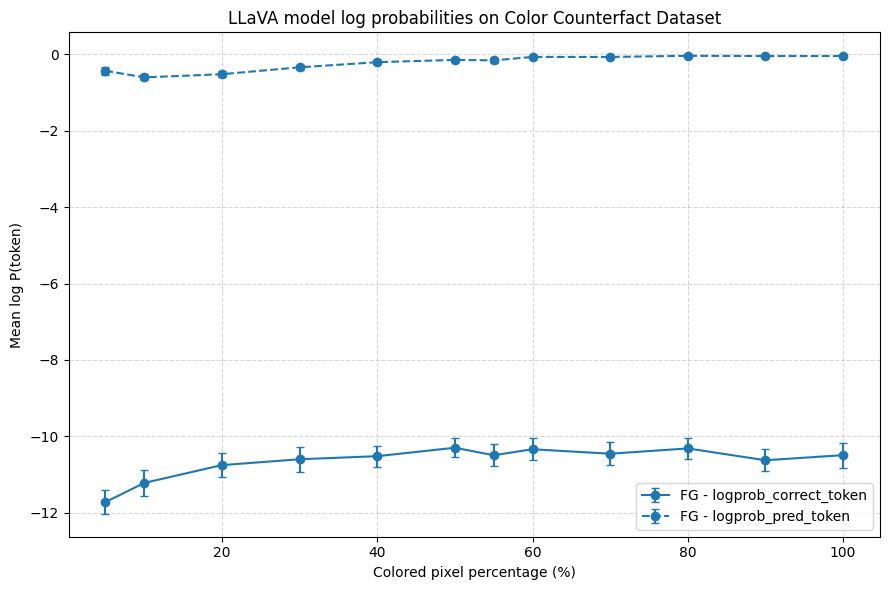

In [18]:
llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv")
llava_cf_pred_df["predicted_color"] = llava_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
llava_cf_pred_df = llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(llava_cf_pred_df)

plot_fg_response_frequencies_bar(llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset", response_col="predicted_color")

plot_model_logprobs(
    llava_cf_pred_df,
    title="LLaVA model log probabilities on Color Counterfact Dataset",
)

## 1.3.2. Counterfact Color Dataset with Introspection Question (LLaVA-NeXT)

In [13]:
suffix = "counterfact"
introsp_llava_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    calibration_value=llava_threshold,
    desc="Evaluating counterfact object colors (counterfact stimuli)",
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_cf_pred_df.to_csv(out_path, index=False)

Evaluating counterfact object colors (counterfact stimuli): 100%|██████████| 412/412 [05:47<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.013361,-10.638361,False,50,50,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.057854,-9.573479,False,50,50,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.317456,-10.669019,False,50,50,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.430259,-11.445884,False,50,50,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.584536,-12.002504,False,50,50,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.122223,-10.622223,False,50,50,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.987835,-10.425335,False,50,50,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.333005,-9.739255,False,50,50,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.083318,-11.067693,False,50,50,counterfact,green,green,FG,70,FG 70% (seq),seq


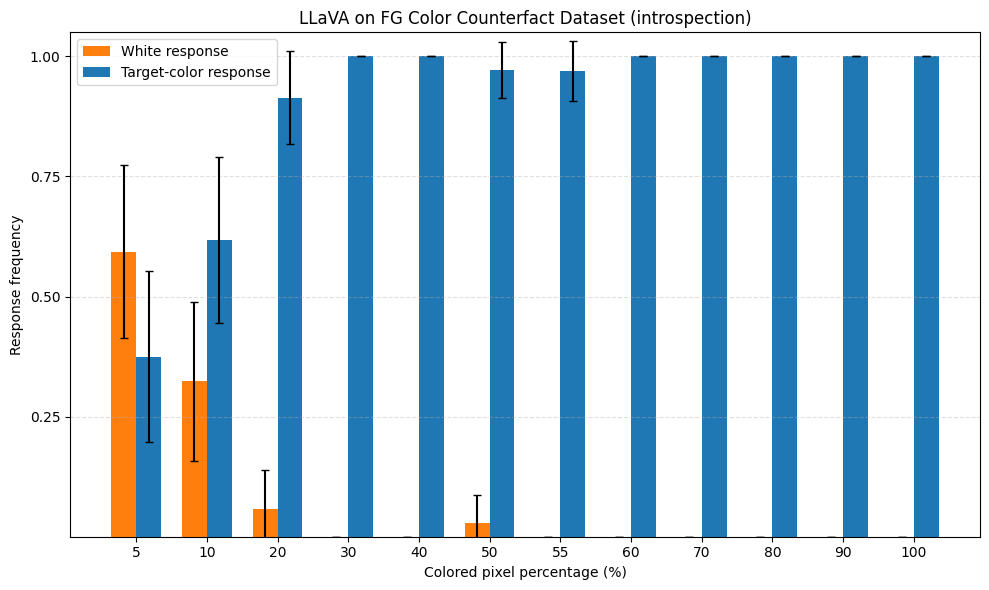

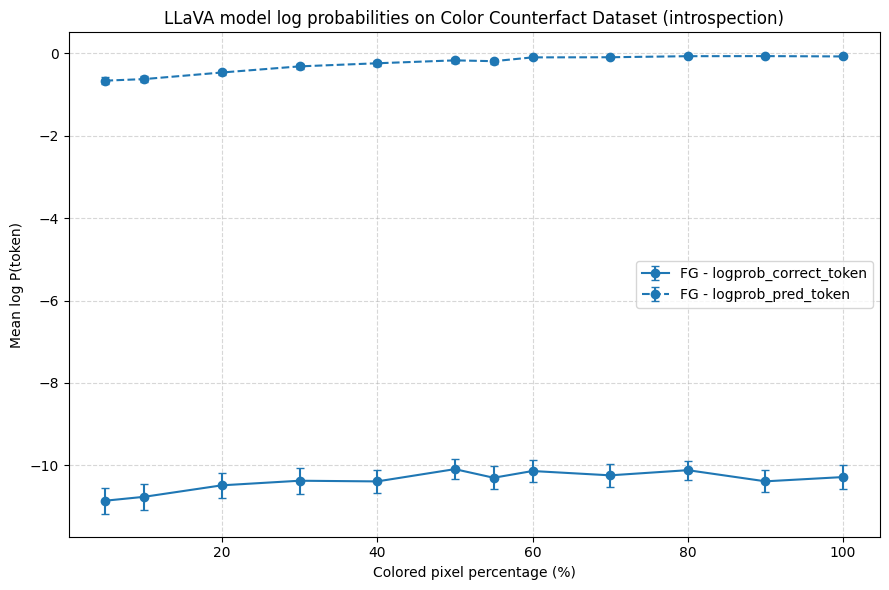

In [20]:
introsp_llava_cf_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_counterfact.csv")
introsp_llava_cf_pred_df["predicted_color"] = introsp_llava_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_llava_cf_pred_df = introsp_llava_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_llava_cf_pred_df)

plot_fg_response_frequencies_bar(introsp_llava_cf_pred_df, title="LLaVA on FG Color Counterfact Dataset (introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_llava_cf_pred_df,
    title="LLaVA model log probabilities on Color Counterfact Dataset (introspection)",
)

## 1.4.1. Shape Dataset (LLaVA-NeXT)

In [14]:
suffix = "shapes"
llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
)

out_path = LLAVA / f"evaluation_{llava_model_name}_{suffix}.csv"
llava_shape_pred_df.to_csv(out_path, index=False)

Evaluating shapes: 100%|██████████| 1331/1331 [18:38<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.107691,-10.045191,False,NaN,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.102478,-9.297791,False,NaN,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.428803,-11.460052,False,NaN,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.186779,-10.139904,False,NaN,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.138488,-10.529114,False,NaN,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.377331,-13.971081,False,NaN,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.159832,-10.464520,False,NaN,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.287228,-12.123166,False,NaN,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.241936,-10.976311,False,NaN,shape,red,white,BG,40,BG 40% (seq),seq


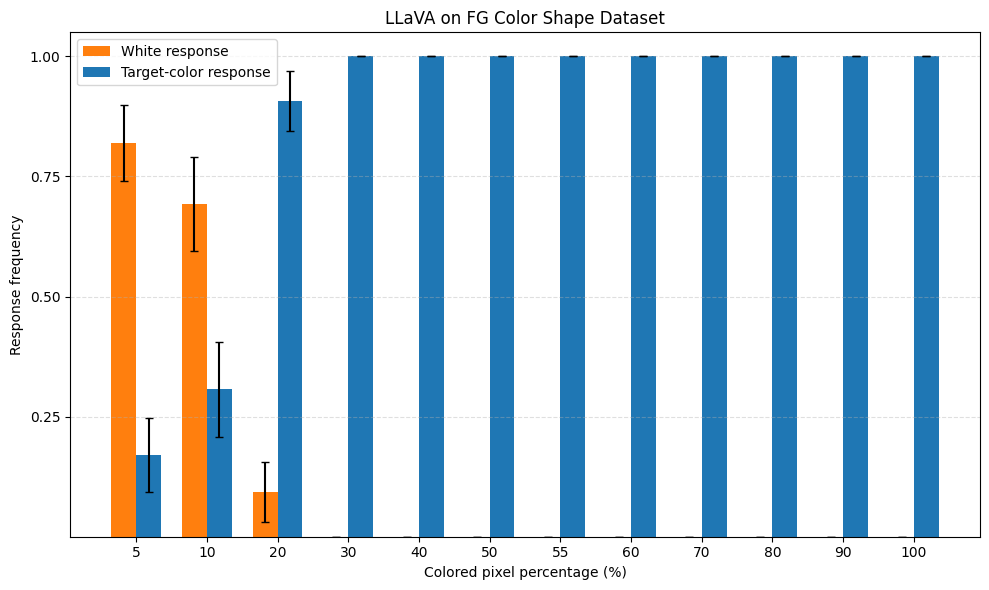

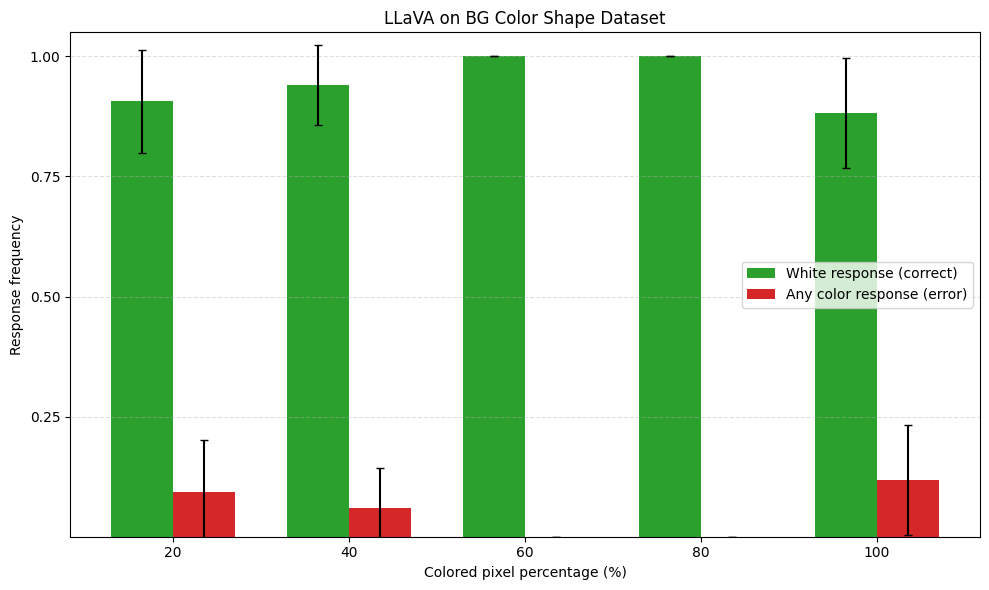

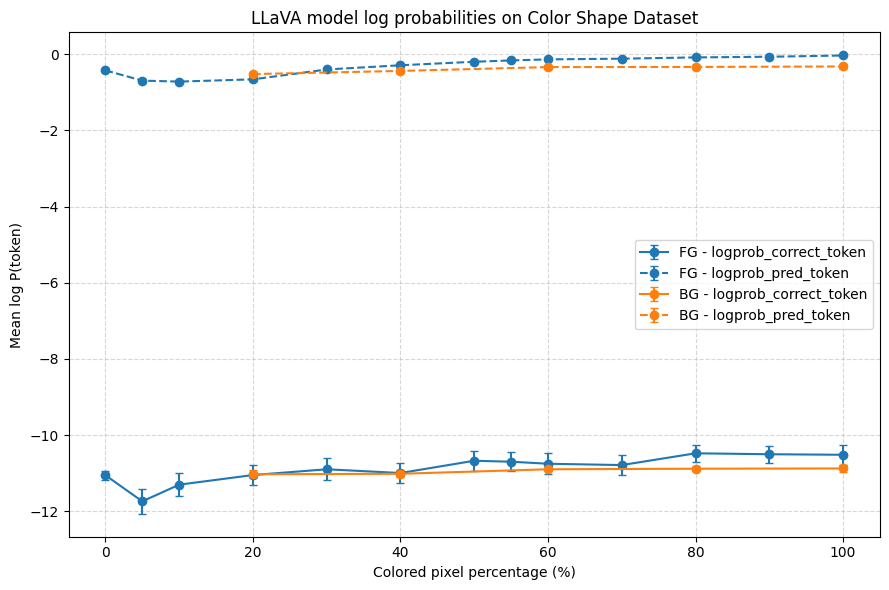

In [21]:
llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_llava-v1.6-mistral-7b-hf_shapes.csv")
llava_shape_pred_df["predicted_color"] = llava_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
llava_shape_pred_df = llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(llava_shape_pred_df)

plot_fg_response_frequencies_bar(llava_shape_pred_df, title="LLaVA on FG Color Shape Dataset", response_col="predicted_color")
plot_bg_response_frequencies_bar(llava_shape_pred_df, title="LLaVA on BG Color Shape Dataset", response_col="predicted_color")

plot_model_logprobs(
    llava_shape_pred_df,
    title="LLaVA model log probabilities on Color Shape Dataset",
)

## 1.4.2. Shape Dataset with Introspection (LLaVA-NeXT)

In [15]:
suffix = "shapes"
introsp_llava_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    processor=llava_processor,
    model=llava_model,
    device=device,
    image_root=DATA,
    desc="Evaluating shapes",
    calibration_value=llava_threshold,
)

out_path = LLAVA / f"evaluation_introsp_{llava_model_name}_{suffix}.csv"
introsp_llava_shape_pred_df.to_csv(out_path, index=False)

Evaluating shapes: 100%|██████████| 1331/1331 [18:49<00:00,  1.18it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.094827,-9.922953,False,50,50,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.085552,-9.335552,False,50,50,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,blue,-0.735709,-10.766959,False,50,50,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.166636,-10.026011,False,50,50,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.170899,-10.319337,False,50,50,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.329158,-13.735408,False,50,50,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.097258,-10.355070,False,50,50,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,black,-0.311987,-11.546362,False,50,50,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.235297,-10.438422,False,50,50,shape,red,white,BG,40,BG 40% (seq),seq


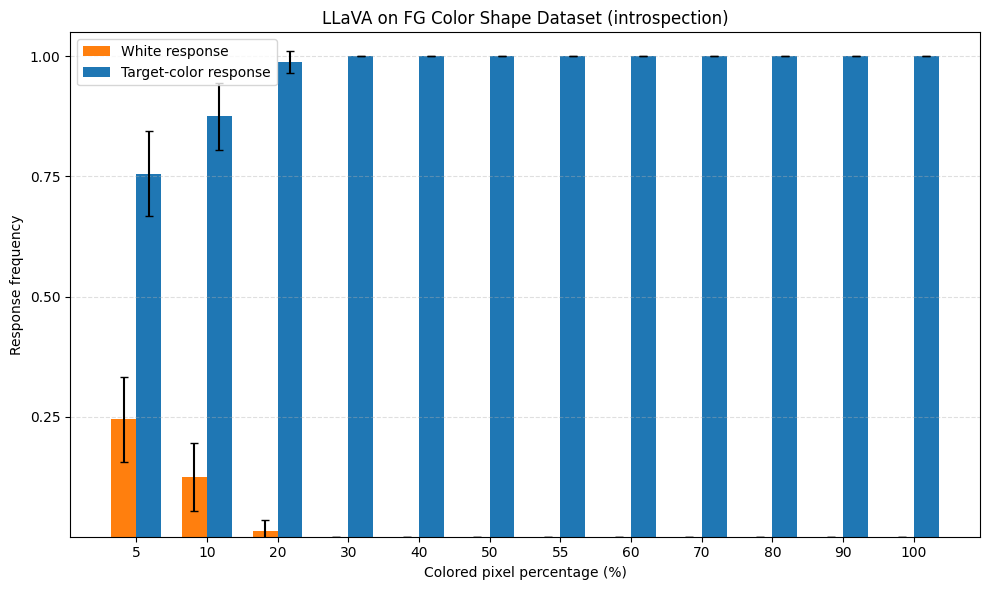

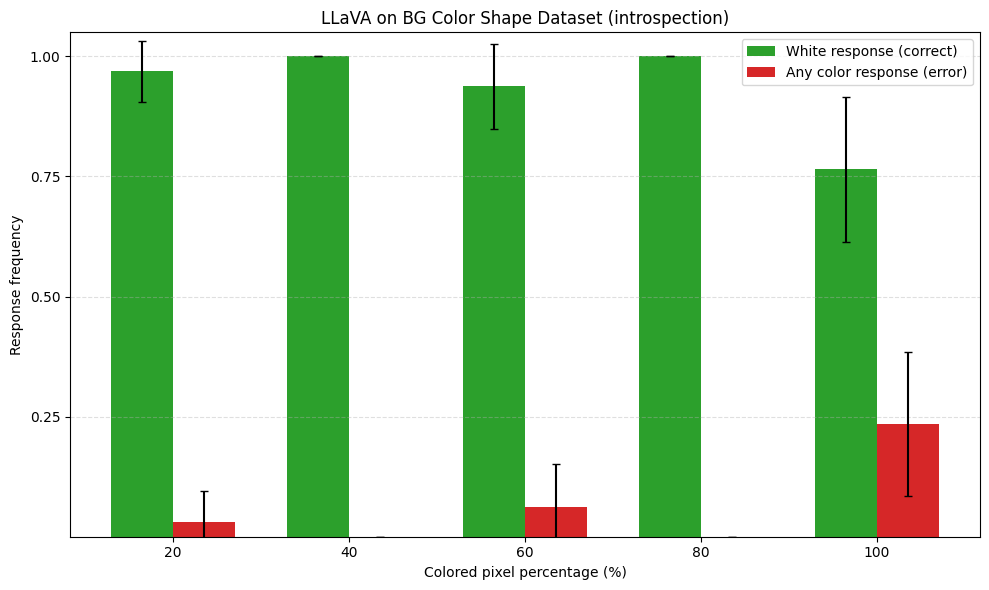

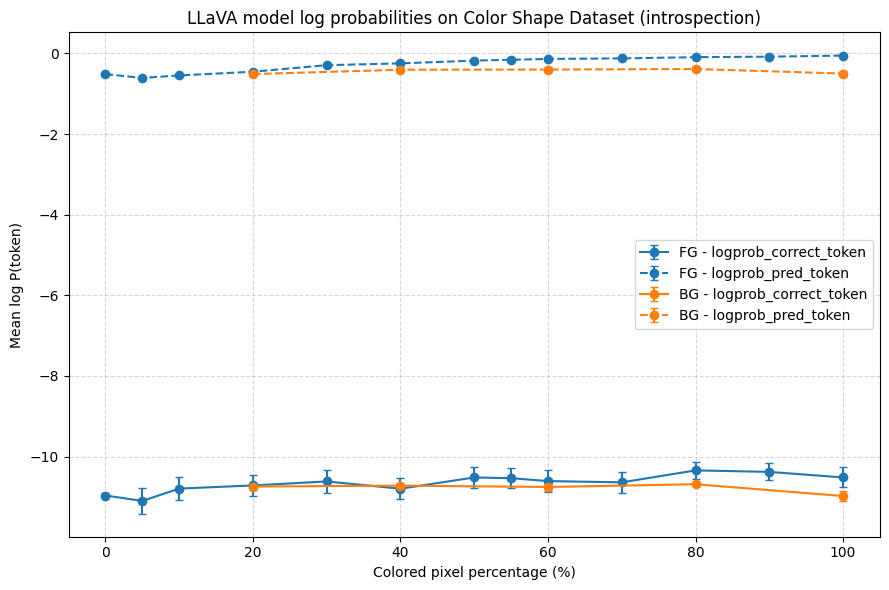

In [22]:
introsp_llava_shape_pred_df = pd.read_csv(LLAVA / "evaluation_introsp_llava-v1.6-mistral-7b-hf_shapes.csv")
introsp_llava_shape_pred_df["predicted_color"] = introsp_llava_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_llava_shape_pred_df = introsp_llava_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_llava_shape_pred_df)

plot_fg_response_frequencies_bar(introsp_llava_shape_pred_df, title="LLaVA on FG Color Shape Dataset (introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(introsp_llava_shape_pred_df, title="LLaVA on BG Color Shape Dataset (introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_llava_shape_pred_df,
    title="LLaVA model log probabilities on Color Shape Dataset (introspection)",
)

# 2. GPT-4o

In [79]:
gpt_model_name = "gpt-4o"
backend = "gpt4"
GPT = DATA / "GPT_results"
GPT.mkdir(parents=True, exist_ok=True)

## 2.1. Introspection question (GPT-4o)

In [80]:
calibration = ask_vlm_introspection_threshold(
    backend="gpt",
    model_name=gpt_model_name,
)

gpt_threshold = calibration["introspection_threshold"]
gpt_raw = calibration["introspection_raw"]
print(gpt_raw)
print(gpt_threshold)

50
50


## 2.2.1. Color Prior Dataset (GPT-4o)

In [9]:
suffix = "image_priors"
gpt_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1260/1260 [20:51<00:00,  1.01it/s] 


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,black,-0.893953,-1.393953,True,NaN,NaN,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,black,-0.318641,NaN,False,NaN,NaN,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.000585,-0.000585,True,NaN,NaN,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.004357,-0.004357,True,NaN,NaN,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.000067,-0.000067,True,NaN,NaN,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.001748,-0.001748,True,NaN,NaN,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.000601,-9.750601,True,NaN,NaN,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.025134,-0.025134,True,NaN,NaN,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.000194,-0.000194,True,NaN,NaN,correct_prior,green,green,FG,50,FG 50% (seq),seq


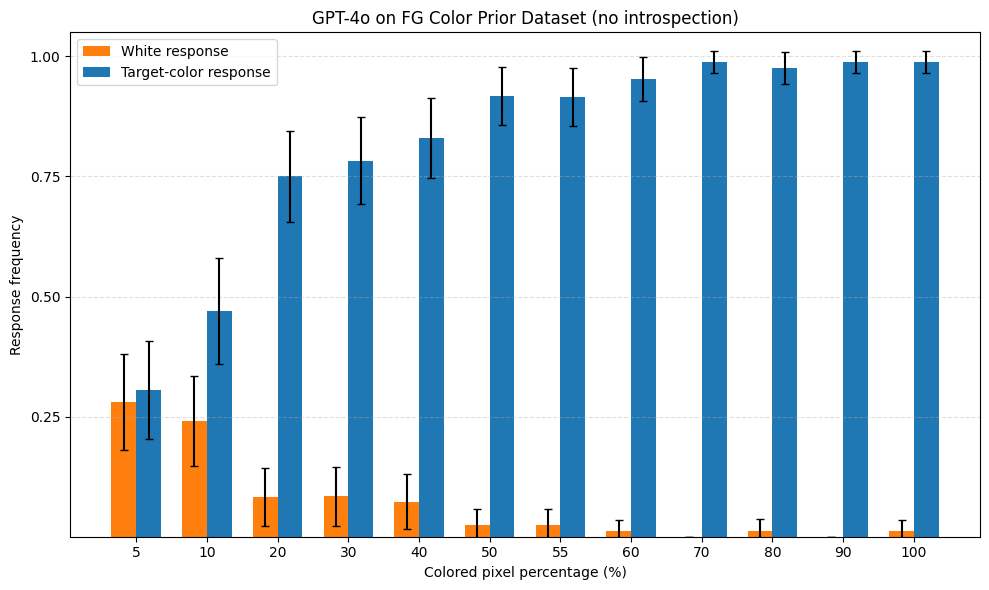

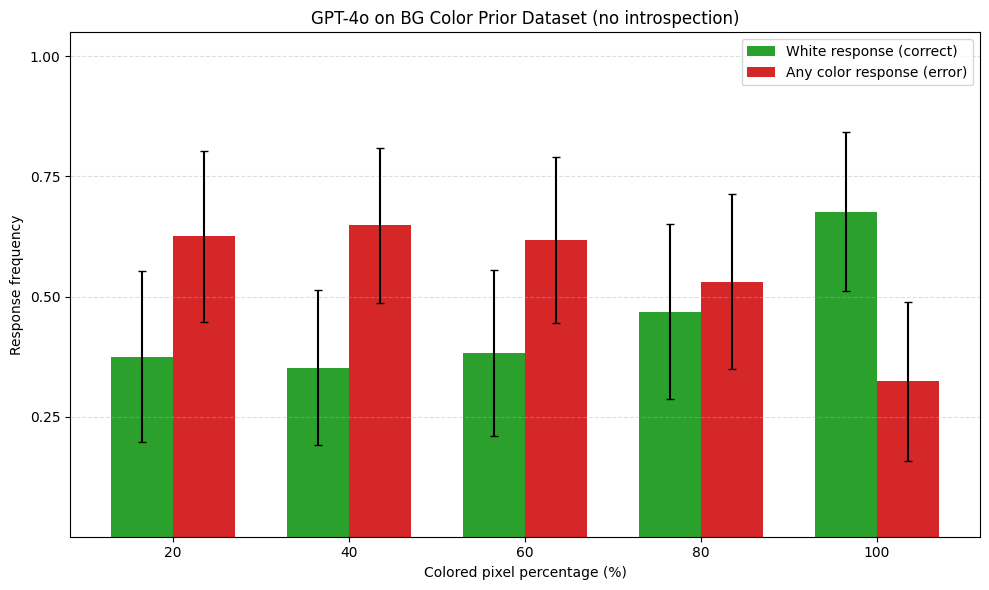

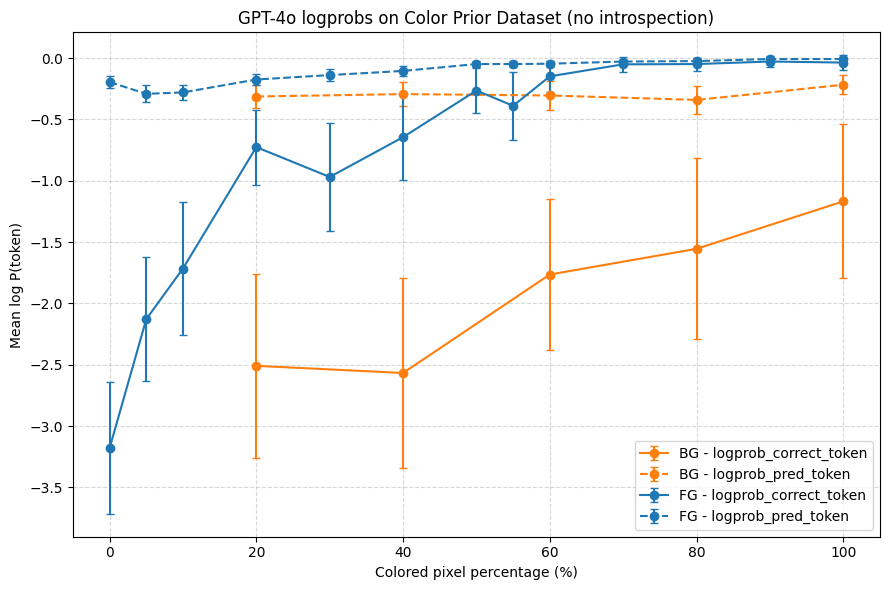

In [24]:
gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_image_priors.csv")
gpt_prior_pred_df["predicted_color"] = gpt_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
gpt_prior_pred_df = gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(gpt_prior_pred_df)

plot_fg_response_frequencies_bar(gpt_prior_pred_df, title="GPT-4o on FG Color Prior Dataset (no introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(gpt_prior_pred_df, title="GPT-4o on BG Color Prior Dataset (no introspection)", response_col="predicted_color")

plot_model_logprobs(
    gpt_prior_pred_df,
    title="GPT-4o logprobs on Color Prior Dataset (no introspection)"
)

## 2.2.2 Color Prior Dataset with Introspection Question (GPT-4o)

In [10]:
suffix = "image_priors"
introsp_gpt_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None
)

out_path = GPT / f"evaluation_introsp_{gpt_model_name}_{suffix}.csv"
introsp_gpt_prior_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1260/1260 [23:59<00:00,  1.14s/it] 


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.033763,-0.033763,True,NaN,60,60,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,white,-0.508399,NaN,False,NaN,60,60,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.000023,-0.000023,True,NaN,60,60,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.018361,-0.018361,True,NaN,60,60,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.003580,-0.003580,True,NaN,60,60,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,white,-0.855955,-0.855955,True,NaN,60,60,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.002821,-6.252821,True,NaN,60,60,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.080644,-0.080644,True,NaN,60,60,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.012303,-0.012303,True,NaN,60,60,correct_prior,green,green,FG,50,FG 50% (seq),seq


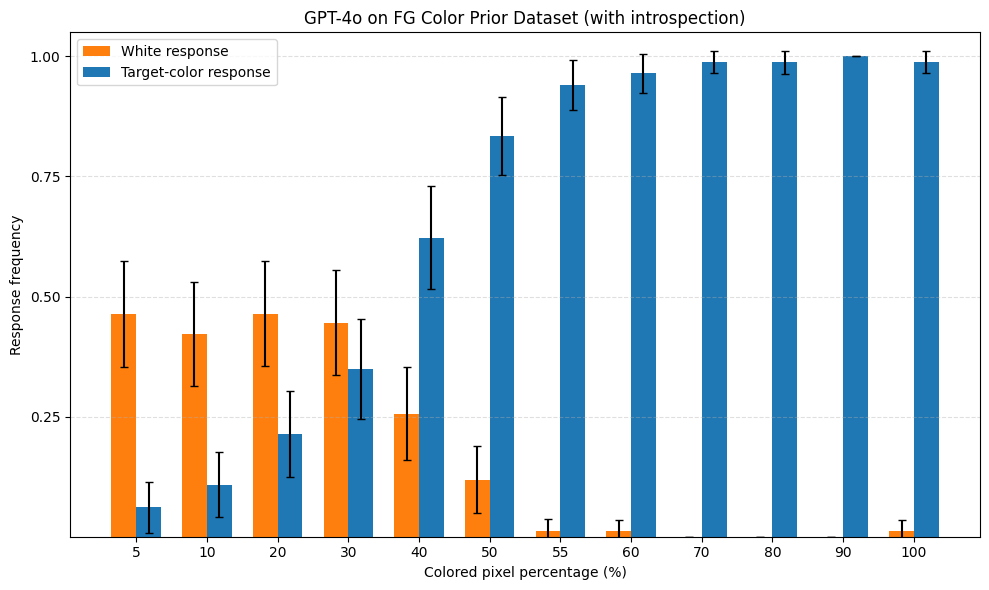

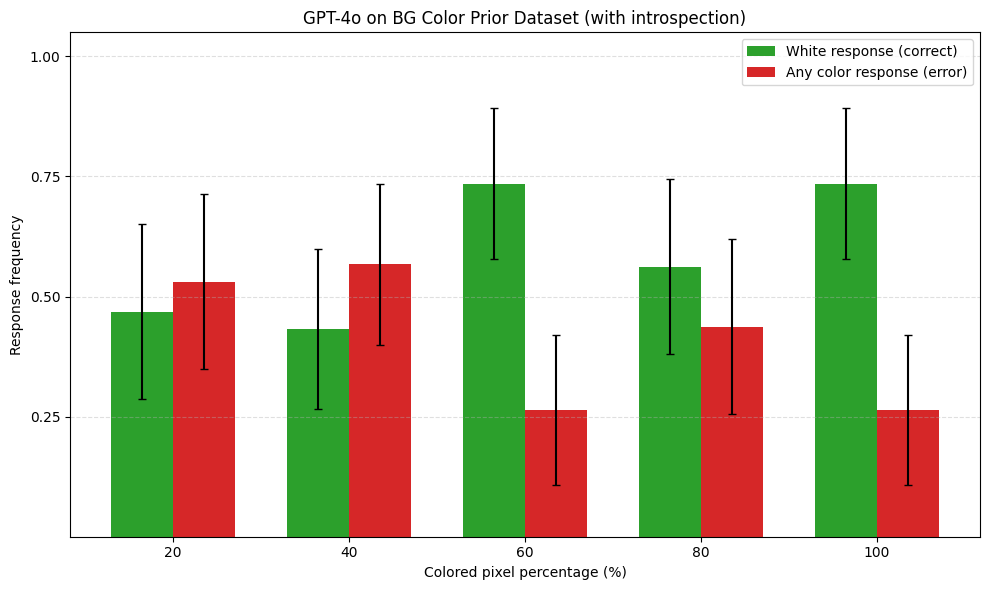

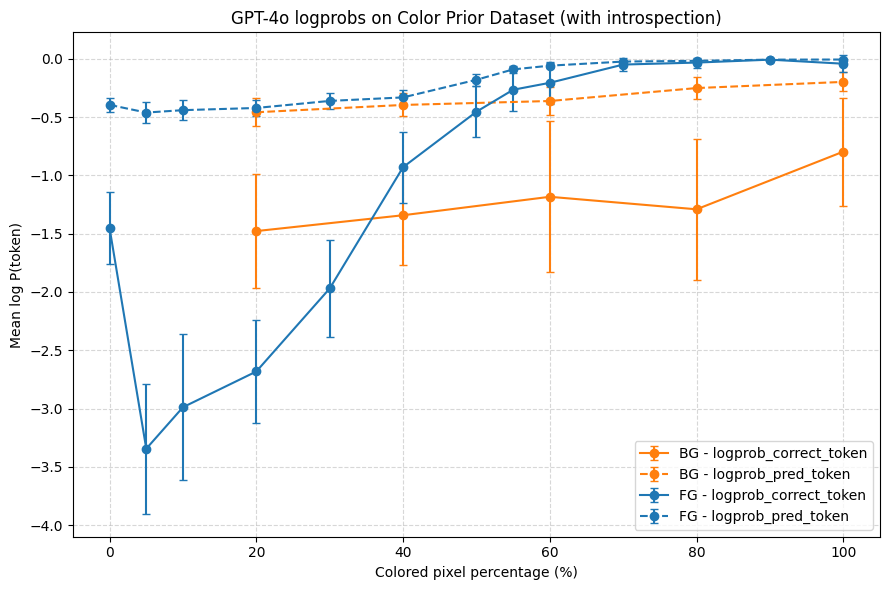

In [25]:
introsp_gpt_prior_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_image_priors.csv")
introsp_gpt_prior_pred_df["predicted_color"] = introsp_gpt_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_prior_pred_df = introsp_gpt_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_gpt_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_prior_pred_df, title="GPT-4o on FG Color Prior Dataset (with introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(introsp_gpt_prior_pred_df, title="GPT-4o on BG Color Prior Dataset (with introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_gpt_prior_pred_df,
    title="GPT-4o logprobs on Color Prior Dataset (with introspection)"
)

## 2.3.1. Counterfact Color Dataset (GPT-4o)

In [28]:
suffix = "counterfact"
gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [08:29<00:00,  1.24s/it]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.000057,-0.000057,True,NaN,NaN,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.001990,-0.001990,True,NaN,NaN,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,black,-1.084120,-1.584120,True,NaN,NaN,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.008513,-0.008513,True,NaN,NaN,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,black,-0.541036,-3.541036,True,NaN,NaN,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.070576,-0.070576,True,NaN,NaN,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.083677,-2.583677,True,NaN,NaN,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.346775,-0.346775,True,NaN,NaN,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.000622,-0.000622,True,NaN,NaN,counterfact,green,green,FG,70,FG 70% (seq),seq


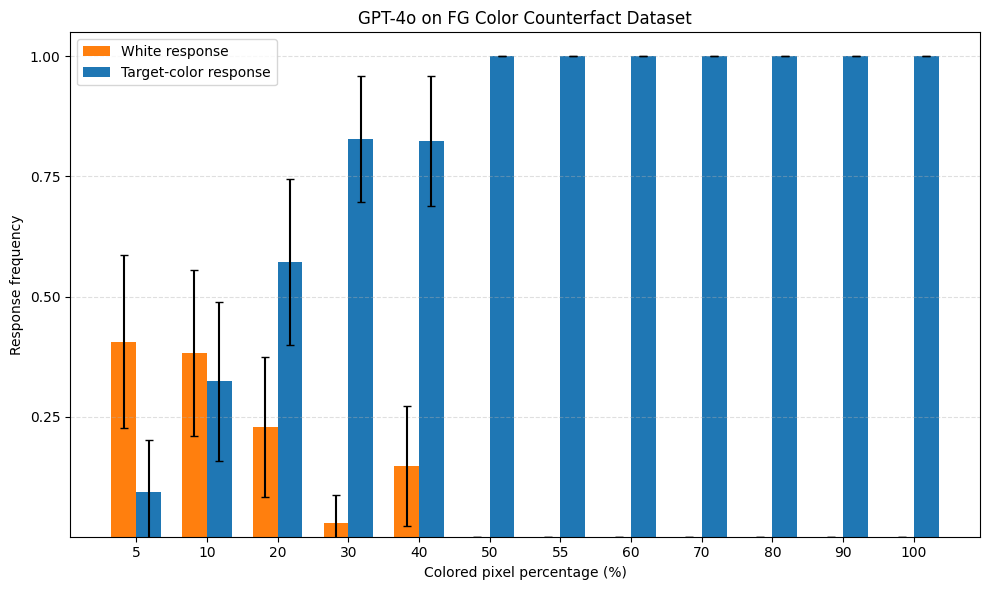

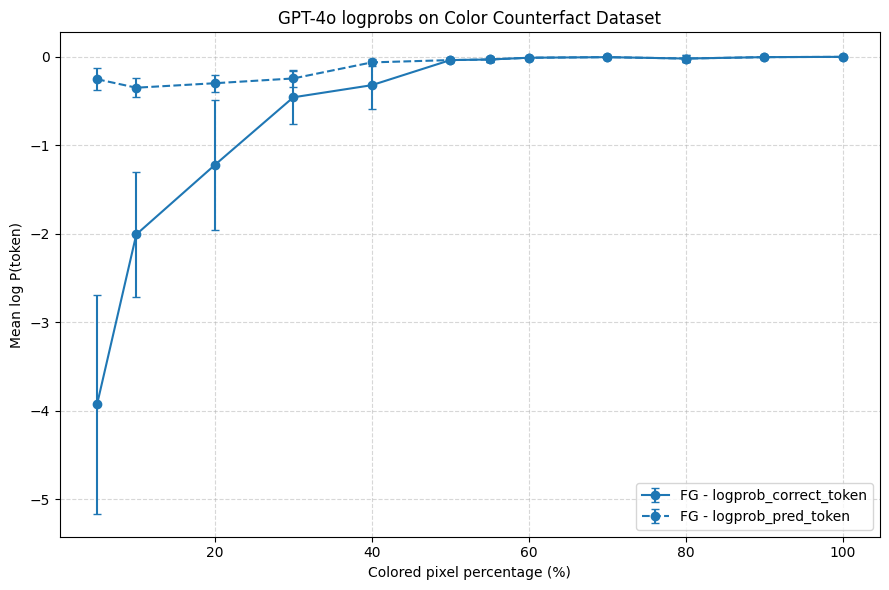

In [30]:
gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_counterfact.csv")
gpt_cf_pred_df["predicted_color"] = gpt_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
gpt_cf_pred_df = gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(gpt_cf_pred_df)

plot_fg_response_frequencies_bar(gpt_cf_pred_df, title="GPT-4o on FG Color Counterfact Dataset", response_col="predicted_color")

plot_model_logprobs(
    gpt_cf_pred_df,
    title="GPT-4o logprobs on Color Counterfact Dataset"
)

## 2.3.2. Counterfact Color Dataset with Introspection Question (GPT-4o)

In [12]:
suffix = "counterfact"
introsp_gpt_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None
)

out_path = GPT / f"evaluation_introsp_{gpt_model_name}_{suffix}.csv"
introsp_gpt_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [07:33<00:00,  1.10s/it]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.000158,-0.000158,True,NaN,60,60,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.033372,-0.033372,True,NaN,60,60,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,other,-0.637780,NaN,False,NaN,60,60,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.492006,-0.492006,True,NaN,60,60,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.358402,-5.358402,True,NaN,60,60,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,white,-0.170573,-3.920573,True,NaN,60,60,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,black,-0.075540,-3.825540,True,NaN,60,60,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.717668,-0.717668,True,NaN,60,60,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.002412,-0.002412,True,NaN,60,60,counterfact,green,green,FG,70,FG 70% (seq),seq


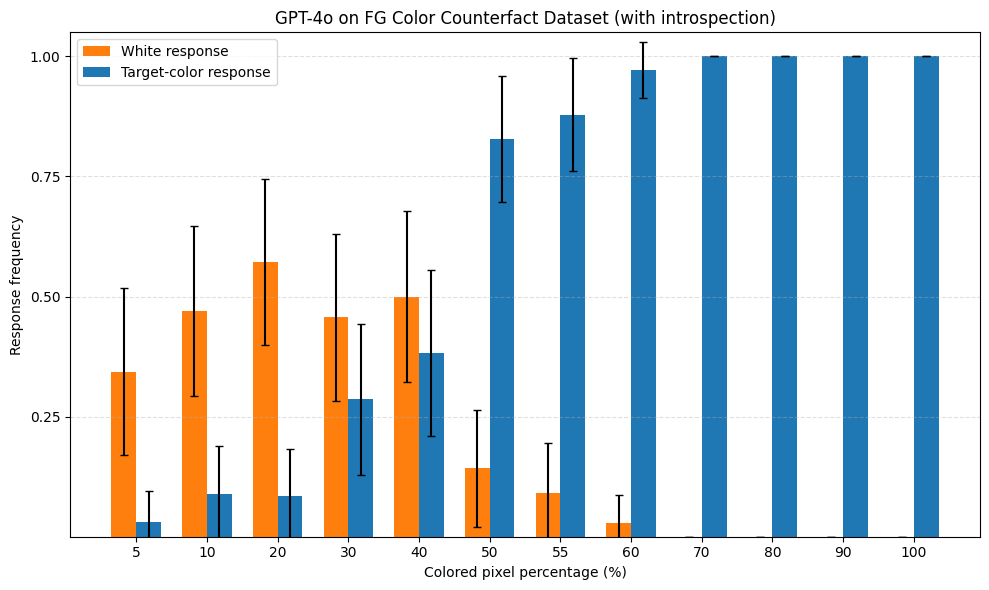

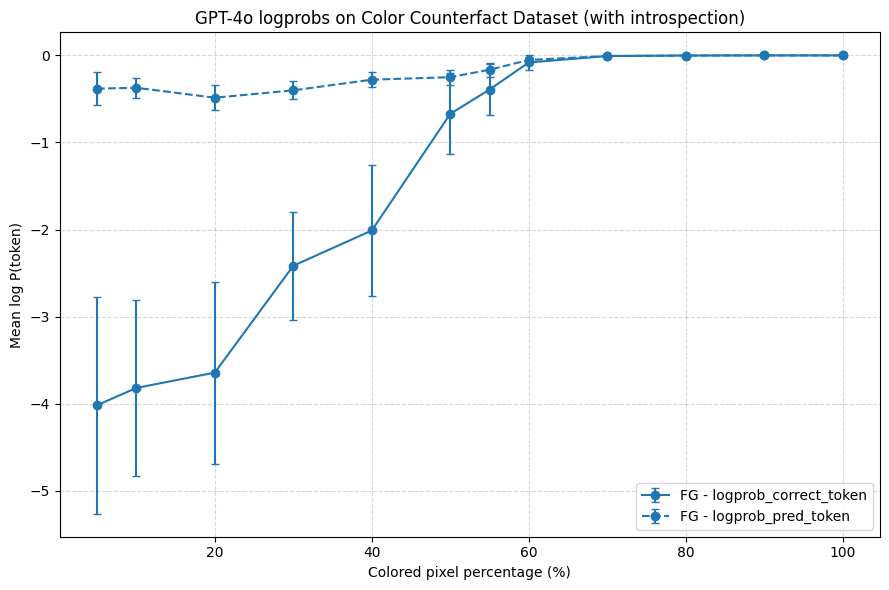

In [31]:
introsp_gpt_cf_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_counterfact.csv")
introsp_gpt_cf_pred_df["predicted_color"] = introsp_gpt_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_cf_pred_df = introsp_gpt_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_gpt_cf_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_cf_pred_df, title="GPT-4o on FG Color Counterfact Dataset (with introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_gpt_cf_pred_df,
    title="GPT-4o logprobs on Color Counterfact Dataset (with introspection)"
)

## 2.4.1. Shape Dataset (GPT-4o)

In [32]:
suffix = "shapes"
gpt_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    device=None,   # ignored for GPT
)

out_path = GPT / f"evaluation_{gpt_model_name}_{suffix}.csv"
gpt_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [17:21<00:00,  1.28it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.000733,-0.000733,True,NaN,NaN,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.001189,-0.001189,True,NaN,NaN,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.003022,-6.253022,True,NaN,NaN,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.002968,-0.002968,True,NaN,NaN,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.000303,-0.000303,True,NaN,NaN,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.209264,-0.209264,True,NaN,NaN,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.005000,-0.005000,True,NaN,NaN,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.705035,-0.705035,True,NaN,NaN,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.000099,-0.000099,True,NaN,NaN,shape,red,white,BG,40,BG 40% (seq),seq


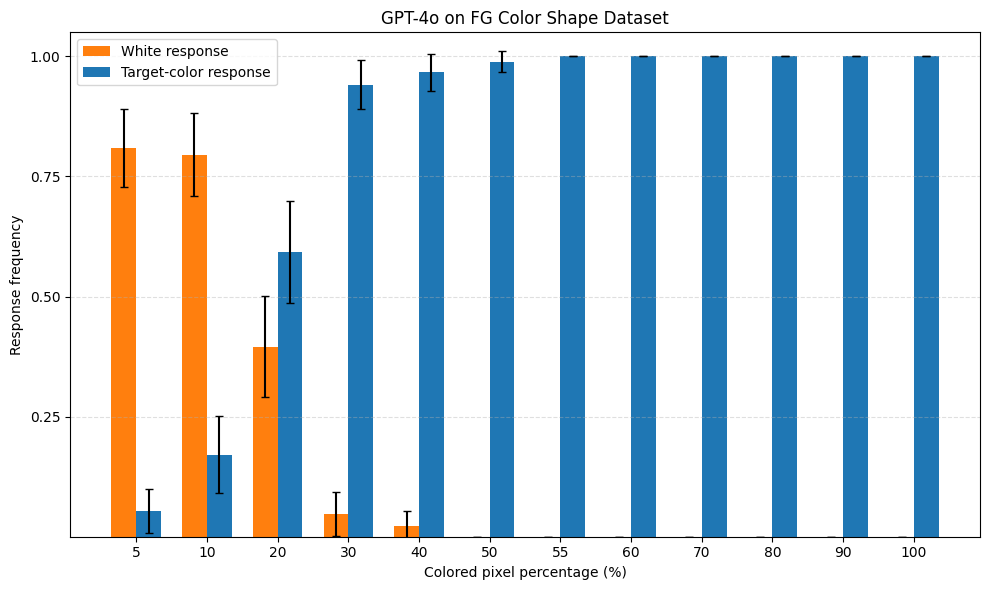

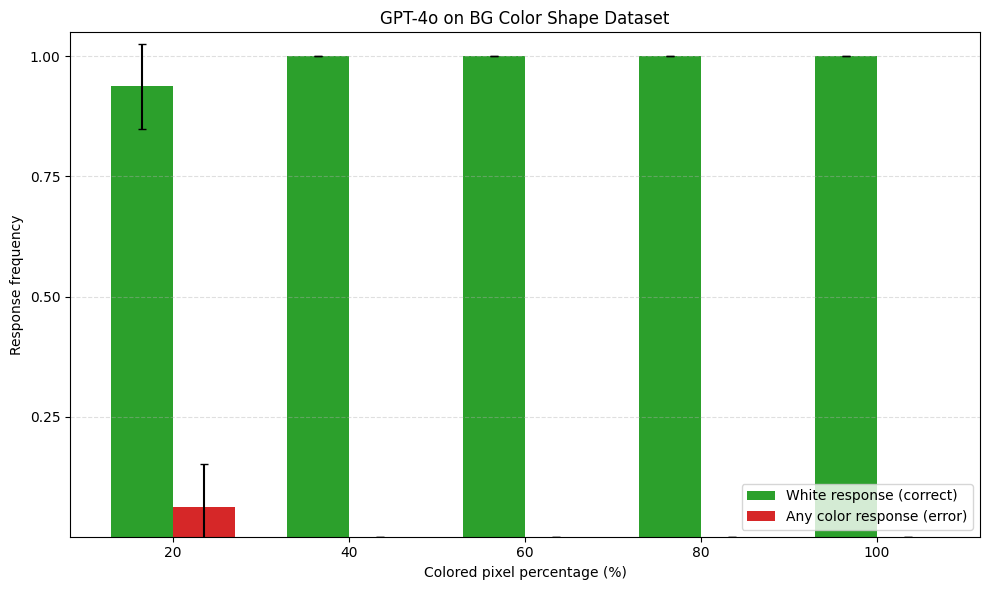

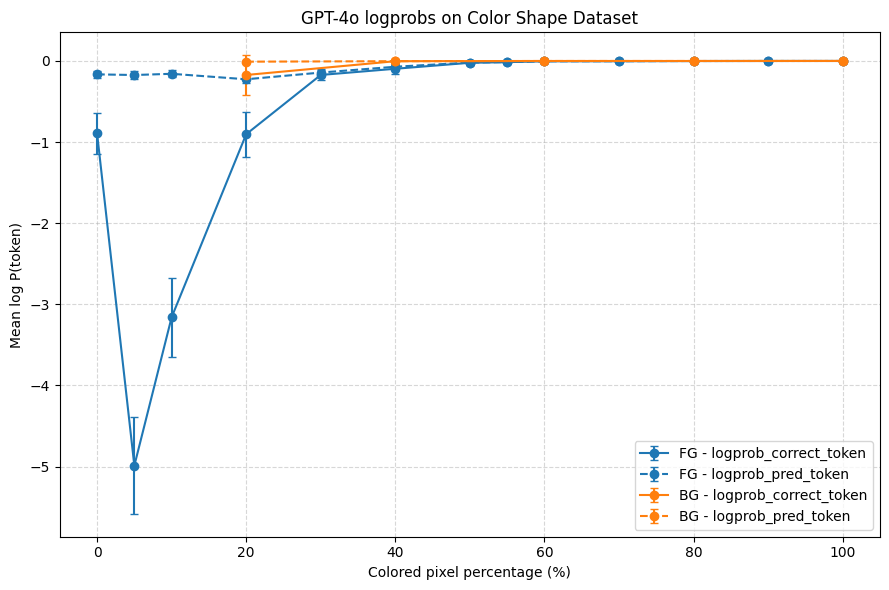

In [34]:
gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_gpt-4o_shapes.csv")
gpt_shape_pred_df["predicted_color"] = gpt_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
gpt_shape_pred_df = gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(gpt_shape_pred_df)

plot_fg_response_frequencies_bar(gpt_shape_pred_df, title="GPT-4o on FG Color Shape Dataset", response_col="predicted_color")
plot_bg_response_frequencies_bar(gpt_shape_pred_df, title="GPT-4o on BG Color Shape Dataset", response_col="predicted_color")

plot_model_logprobs(
    gpt_shape_pred_df,
    title="GPT-4o logprobs on Color Shape Dataset"
)

## 2.4.1. Shape Dataset with Introspection Question (GPT-4o)

In [41]:
suffix = "shapes"
introsp_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend=backend,
    model_name=gpt_model_name,
    image_root=DATA,
    calibration_value=gpt_threshold,
    device=None)

out_path = GPT / f"evaluation_introsp_{gpt_model_name}_{suffix}.csv"
introsp_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [18:42<00:00,  1.19it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,prob_correct_this,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.002674,-0.002674,True,NaN,60,60,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,white,-0.382449,-1.382449,True,NaN,60,60,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,white,-0.003943,NaN,False,NaN,60,60,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.099861,-0.099861,True,NaN,60,60,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.000016,-0.000016,True,NaN,60,60,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,white,-0.131223,-2.131223,True,NaN,60,60,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.000063,-0.000063,True,NaN,60,60,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.404295,-0.404295,True,NaN,60,60,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.000365,-0.000365,True,NaN,60,60,shape,red,white,BG,40,BG 40% (seq),seq


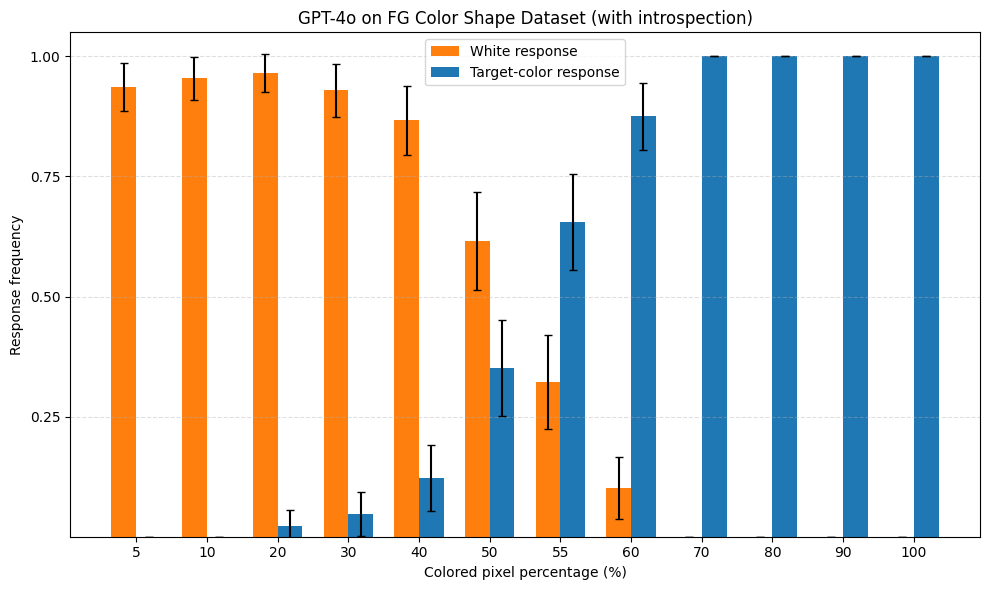

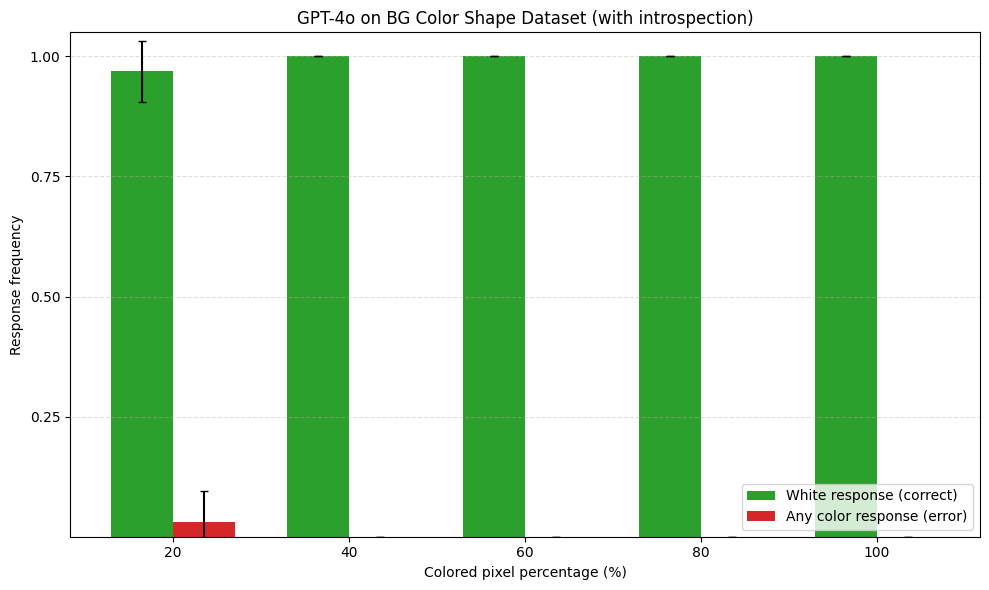

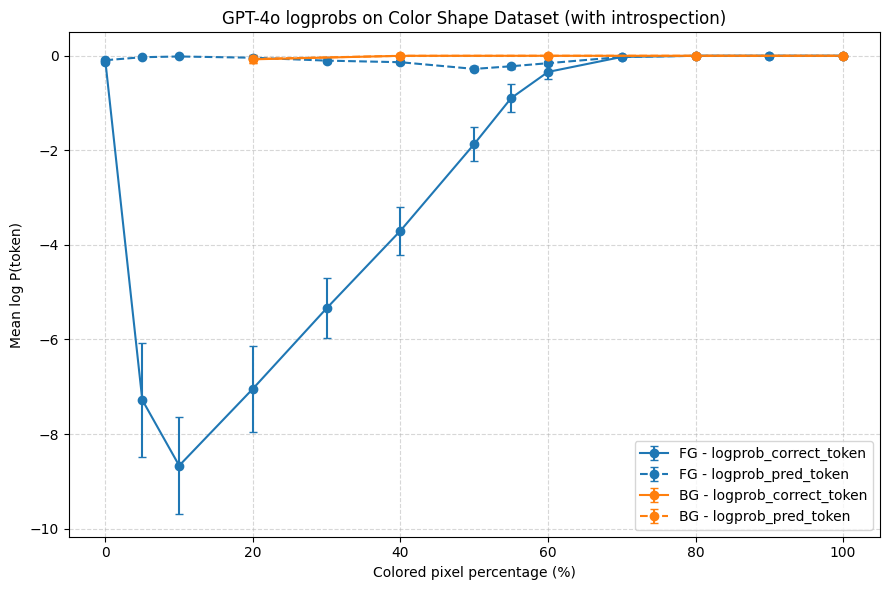

In [42]:
introsp_gpt_shape_pred_df = pd.read_csv(GPT / "evaluation_introsp_gpt-4o_shapes.csv")
introsp_gpt_shape_pred_df["predicted_color"] = introsp_gpt_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_gpt_shape_pred_df = introsp_gpt_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_gpt_shape_pred_df)

plot_fg_response_frequencies_bar(introsp_gpt_shape_pred_df, title="GPT-4o on FG Color Shape Dataset (with introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(introsp_gpt_shape_pred_df, title="GPT-4o on BG Color Shape Dataset (with introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_gpt_shape_pred_df,
    title="GPT-4o logprobs on Color Shape Dataset (with introspection)"
)

# 3. Qwen3-VL

In [81]:
qwen_model_name = "Qwen3-VL-8B-Instruct"

qwen_processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    trust_remote_code=True
)

qwen_model = AutoModelForVision2Seq.from_pretrained(
    "Qwen/Qwen3-VL-8B-Instruct",
    device_map="auto",
    dtype=torch.float16,
    low_cpu_mem_usage=True,
    quantization_config=bnb_config,
    trust_remote_code=True,
).to(device)


QWEN = DATA / "Qwen3_results"
QWEN.mkdir(parents=True, exist_ok=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 3.1. Introspection question (Qwen3-VL)

In [82]:
calibration = ask_vlm_introspection_threshold(
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    model_name=qwen_model_name,
)

qwen_threshold = calibration["introspection_threshold"]
qwen_raw = calibration["introspection_raw"]
print(qwen_raw)
print(qwen_threshold)

user
for any object, x% of its pixels should be colored for it to be considered that color.
for example, imagine an image of a banana, where only part of the banana in the image is colored yellow.
at what point would you personally say that the banana in the image is yellow?
what value should x% be?
please only answer with a single number between 0 and 100.
assistant
50
50


## 3.2.1. Color Prior Dataset (Qwen3-VL)

In [39]:
suffix = "image_priors"
qwen_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = QWEN / f"evaluation_{qwen_model_name}_{suffix}.csv"
qwen_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [13:03<00:00,  1.61it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,white,-0.111229,-0.111229,True,NaN,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-0.680644,-0.711894,True,NaN,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.020549,-0.020549,True,NaN,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.045944,-6.764694,True,NaN,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.040452,-0.040452,True,NaN,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.376979,-1.158229,True,NaN,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.408832,-6.846333,True,NaN,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.562393,-0.562393,True,NaN,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.450941,-0.450941,True,NaN,correct_prior,green,green,FG,50,FG 50% (seq),seq


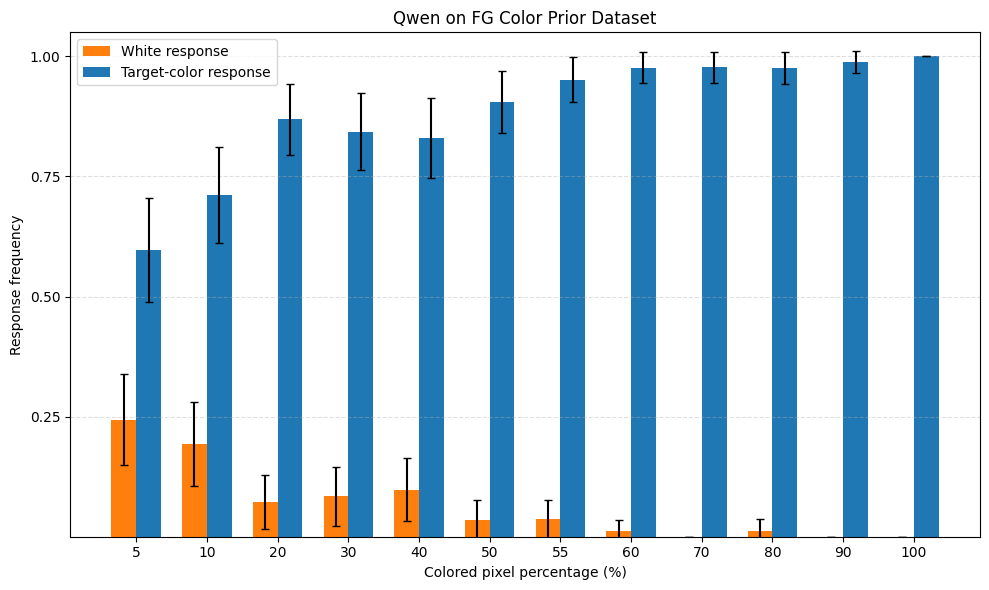

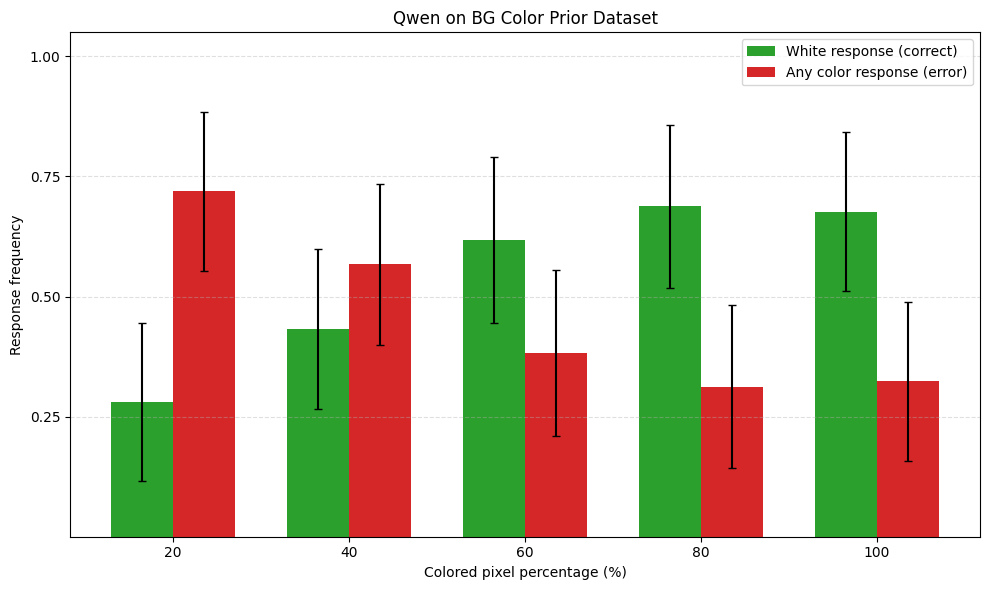

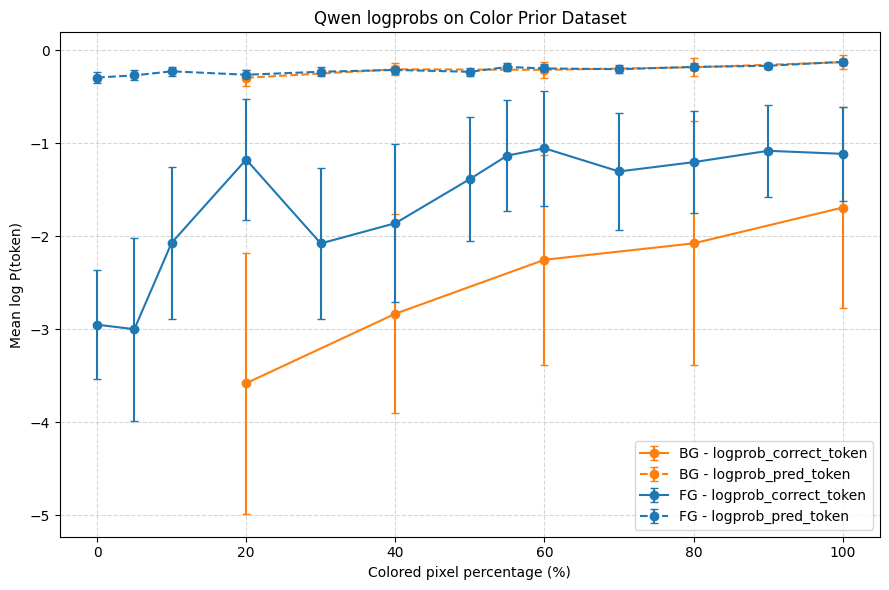

In [45]:
qwen_prior_pred_df = pd.read_csv(QWEN / f"evaluation_{qwen_model_name}_image_priors.csv")
qwen_prior_pred_df["predicted_color"] = qwen_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
qwen_prior_pred_df = qwen_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(qwen_prior_pred_df)

plot_fg_response_frequencies_bar(qwen_prior_pred_df, title="Qwen on FG Color Prior Dataset", response_col="predicted_color")
plot_bg_response_frequencies_bar(qwen_prior_pred_df, title="Qwen on BG Color Prior Dataset", response_col="predicted_color")

plot_model_logprobs(
    qwen_prior_pred_df,
    title="Qwen logprobs on Color Prior Dataset"
)

## 3.2.2. Color Prior Dataset with Introspection Question (Qwen3-VL)

In [40]:
suffix = "image_priors"
introsp_qwen_prior_pred_df = evaluate_vlm_on_stimuli(
    prior_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA,
    calibration_value=qwen_threshold,
    desc="Evaluating canonical object colors (correct-prior stimuli)",
)

out_path = QWEN / f"introsp_evaluation_{qwen_model_name}_{suffix}.csv"
introsp_qwen_prior_pred_df.to_csv(out_path, index=False)

Evaluating canonical object colors (correct-prior stimuli): 100%|██████████| 1260/1260 [12:57<00:00,  1.62it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,cheese,white,yellow,-0.226642,-1.601642,True,50,50,correct_prior,yellow,white,BG,80,BG 80% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,espresso maker,red,red,-0.042914,-0.042914,True,50,50,correct_prior,red,red,FG,5,FG 5% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,tile roof,red,red,-0.011053,-0.011053,True,50,50,correct_prior,red,red,FG,100,FG 100% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,cloud,grey,grey,-0.046637,-6.577887,True,50,50,correct_prior,grey,grey,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,brown,brown,-0.003491,-0.003491,True,50,50,correct_prior,brown,brown,FG,100,FG 100% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,/mnt/lustre/work/eickhoff/esx061/color-concept...,eggplant,purple,purple,-0.155674,-0.155674,True,50,50,correct_prior,purple,purple,FG,40,FG 40% (seq),seq
1256,/mnt/lustre/work/eickhoff/esx061/color-concept...,rattlesnake,white,black,-0.101357,-2.413857,True,50,50,correct_prior,brown,white,FG,0,FG 0% (seq),seq
1257,/mnt/lustre/work/eickhoff/esx061/color-concept...,tow truck,brown,brown,-0.072086,-0.072086,True,50,50,correct_prior,brown,brown,FG,40,FG 40% (seq),seq
1258,/mnt/lustre/work/eickhoff/esx061/color-concept...,snake,green,green,-0.045712,-0.045712,True,50,50,correct_prior,green,green,FG,50,FG 50% (seq),seq


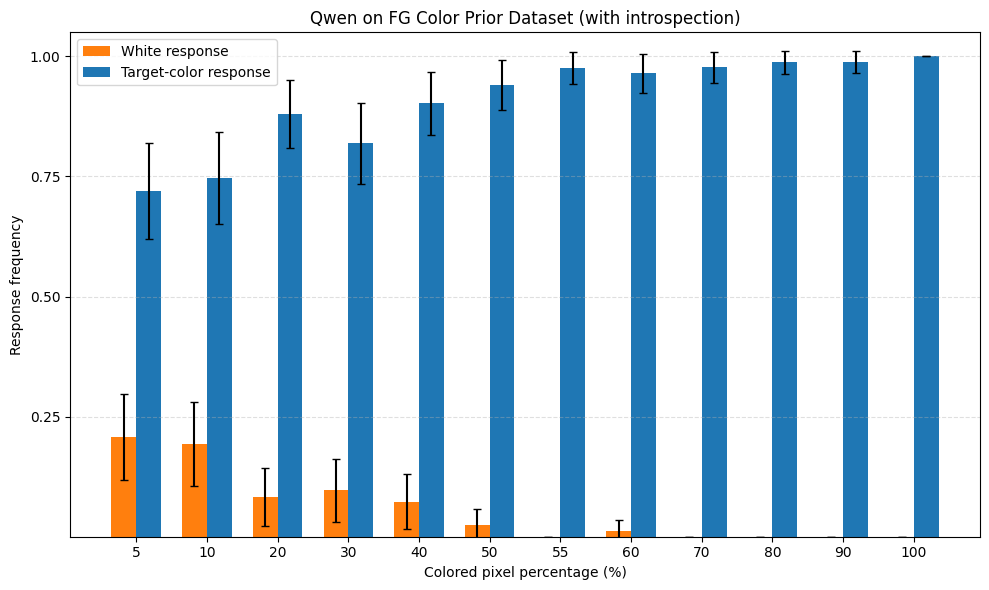

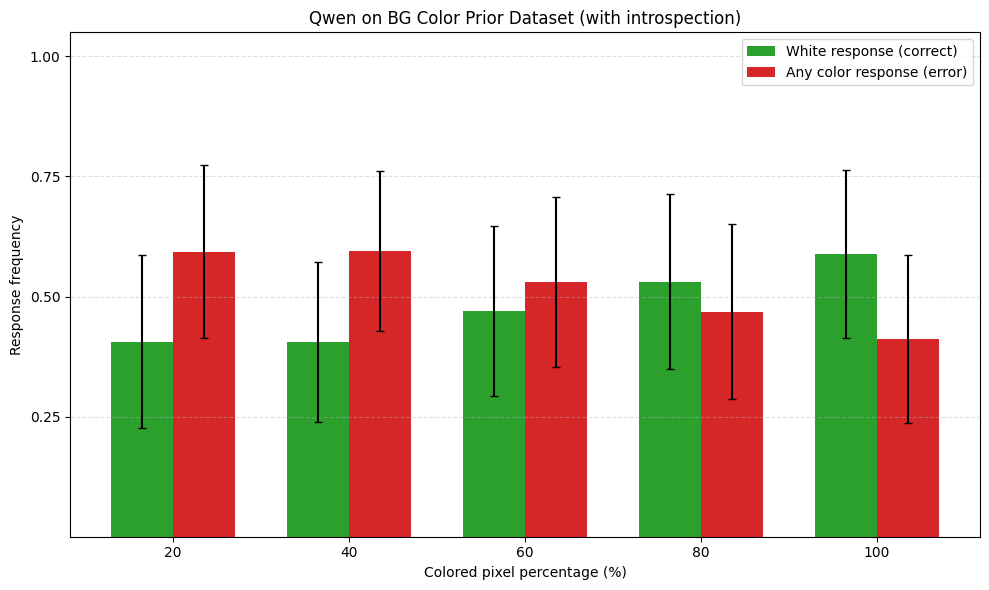

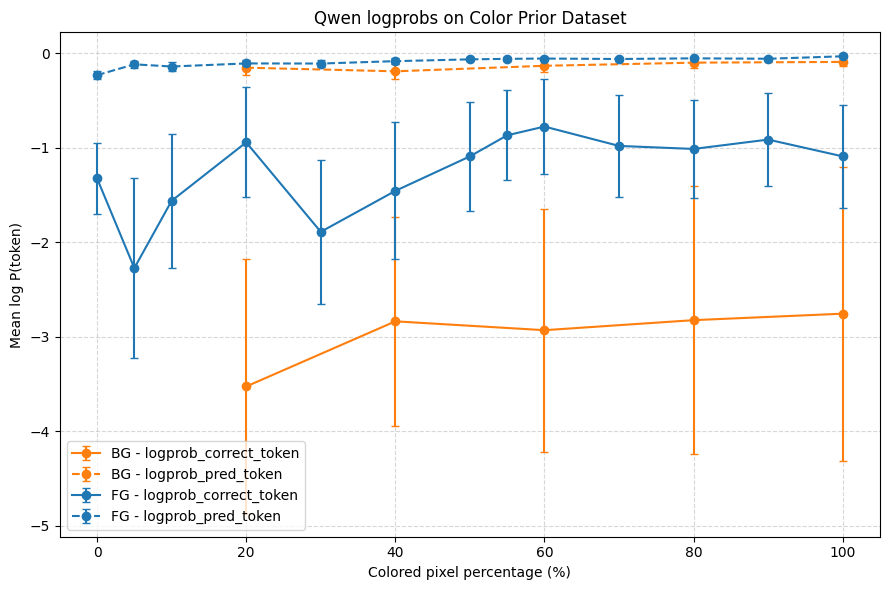

In [46]:
introsp_qwen_prior_pred_df = pd.read_csv(QWEN / f"introsp_evaluation_{qwen_model_name}_image_priors.csv")
introsp_qwen_prior_pred_df["predicted_color"] = introsp_qwen_prior_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_qwen_prior_pred_df = introsp_qwen_prior_pred_df.merge(prior_df, on=["image_path", "object"])
display(introsp_qwen_prior_pred_df)

plot_fg_response_frequencies_bar(introsp_qwen_prior_pred_df, title="Qwen on FG Color Prior Dataset (with introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(introsp_qwen_prior_pred_df, title="Qwen on BG Color Prior Dataset (with introspection)", response_col="predicted_color")
plot_model_logprobs(
    introsp_qwen_prior_pred_df,
    title="Qwen logprobs on Color Prior Dataset"
)

## 3.3.1. Counterfact Color Dataset (Qwen3-VL)

In [41]:
suffix = "counterfact"
qwen_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA
)

out_path = QWEN / f"evaluation_{qwen_model_name}_{suffix}.csv"
qwen_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [04:13<00:00,  1.62it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.043000,-0.043000,True,NaN,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.016559,-0.016559,True,NaN,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.086337,-0.086337,True,NaN,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.411360,-0.411360,True,NaN,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.202929,-2.077929,True,NaN,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.142738,-0.142738,True,NaN,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,pink,-0.209336,-0.209336,True,NaN,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.116236,-0.116236,True,NaN,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.562383,-0.562383,True,NaN,counterfact,green,green,FG,70,FG 70% (seq),seq


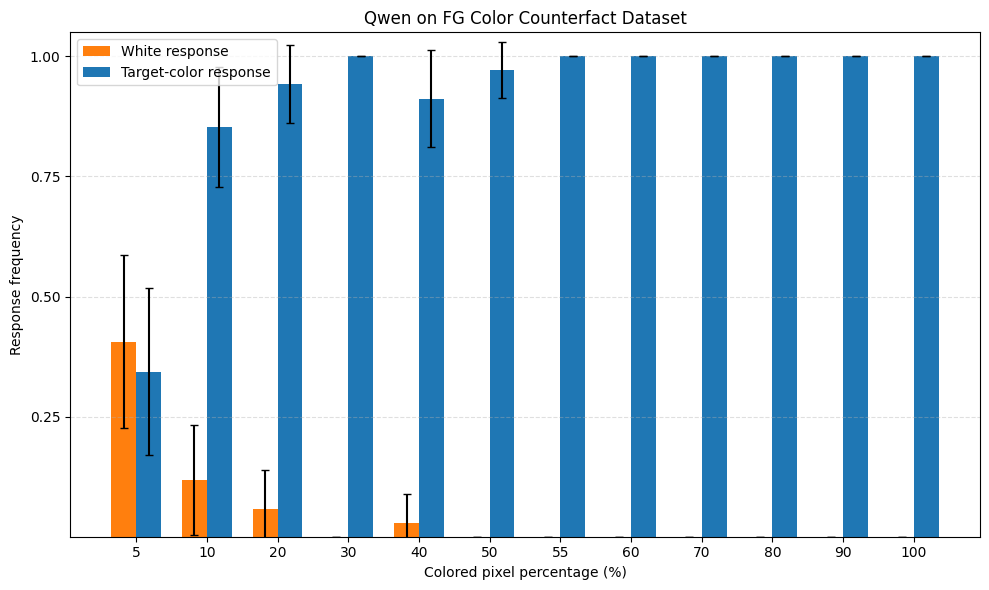

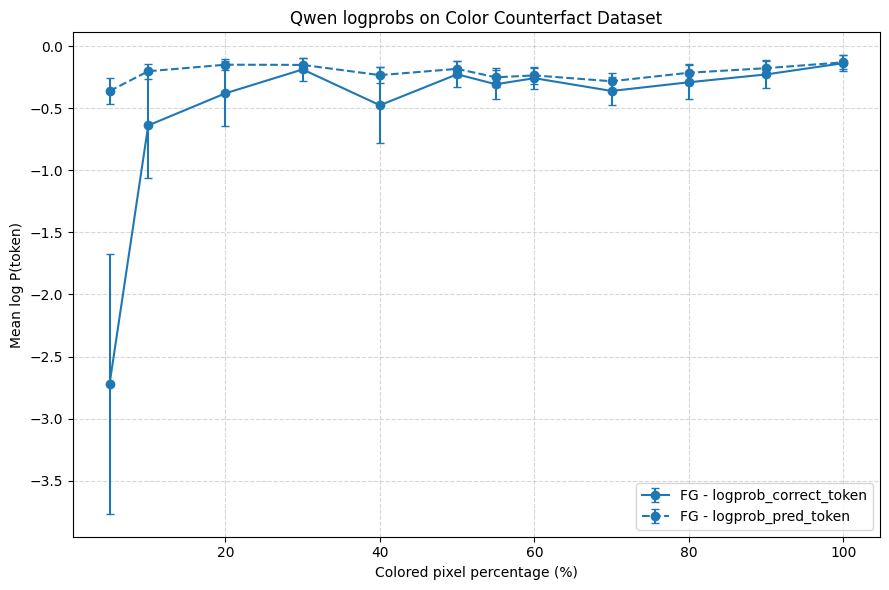

In [57]:
qwen_cf_pred_df = pd.read_csv(QWEN / f"evaluation_{qwen_model_name}_counterfact.csv")
qwen_cf_pred_df["predicted_color"] = qwen_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
qwen_cf_pred_df = qwen_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(qwen_cf_pred_df)


plot_fg_response_frequencies_bar(qwen_cf_pred_df, title="Qwen on FG Color Counterfact Dataset", response_col="predicted_color")

plot_model_logprobs(
    qwen_cf_pred_df,
    title="Qwen logprobs on Color Counterfact Dataset"
)

## 3.3.2. Counterfact Color Dataset with Introspection Question (Qwen3-VL)

In [42]:
suffix = "counterfact"
introsp_qwen_cf_pred_df = evaluate_vlm_on_stimuli(
    counterfact_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    calibration_value=qwen_threshold,
    image_root=DATA
)

out_path = QWEN / f"introsp_evaluation_{qwen_model_name}_{suffix}.csv"
introsp_qwen_cf_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 412/412 [04:11<00:00,  1.64it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,rose,blue,blue,-0.078897,-0.078897,True,50,50,counterfact,blue,blue,FG,100,FG 100% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,sealyham terrier,purple,purple,-0.005944,-0.005944,True,50,50,counterfact,purple,purple,FG,60,FG 60% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,iguana,orange,orange,-0.010746,-0.010746,True,50,50,counterfact,orange,orange,FG,10,FG 10% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,hartebeest,red,red,-0.245520,-0.245520,True,50,50,counterfact,red,red,FG,55,FG 55% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,mouse,red,white,-0.141598,-2.141598,True,50,50,counterfact,red,red,FG,20,FG 20% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,/mnt/lustre/work/eickhoff/esx061/color-concept...,trailer truck,orange,orange,-0.010737,-0.010737,True,50,50,counterfact,orange,orange,FG,40,FG 40% (seq),seq
408,/mnt/lustre/work/eickhoff/esx061/color-concept...,frilled lizard,pink,pink,-0.600624,-0.600624,True,50,50,counterfact,pink,pink,FG,10,FG 10% (seq),seq
409,/mnt/lustre/work/eickhoff/esx061/color-concept...,coho,purple,purple,-0.011065,-0.011065,True,50,50,counterfact,purple,purple,FG,30,FG 30% (seq),seq
410,/mnt/lustre/work/eickhoff/esx061/color-concept...,butternut squash,green,green,-0.025502,-0.025502,True,50,50,counterfact,green,green,FG,70,FG 70% (seq),seq


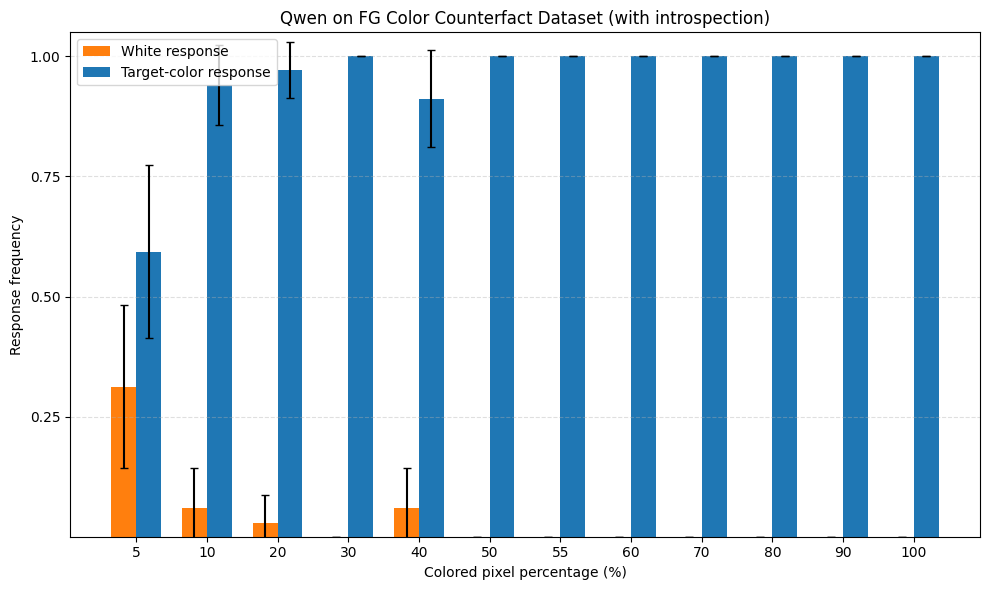

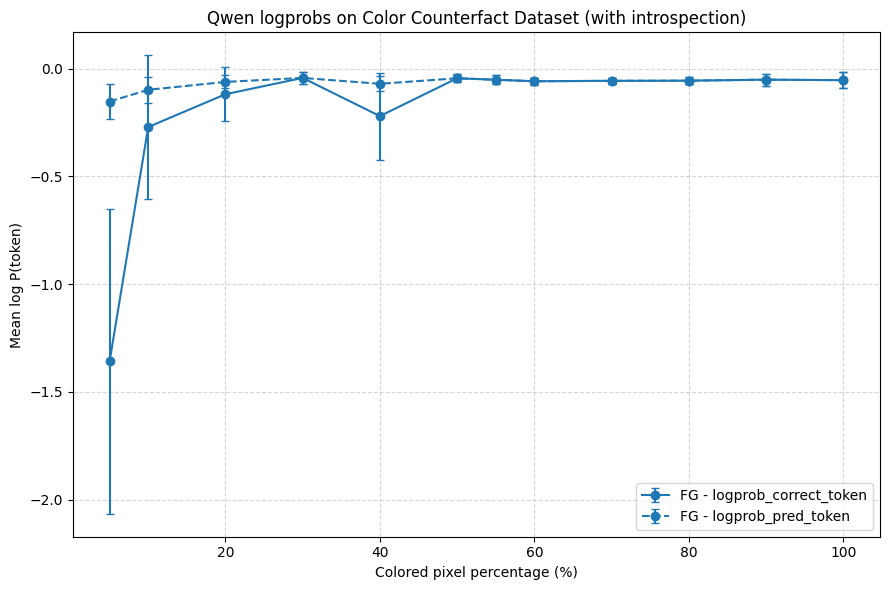

In [58]:
introsp_qwen_cf_pred_df = pd.read_csv(QWEN / f"introsp_evaluation_{qwen_model_name}_counterfact.csv")
introsp_qwen_cf_pred_df["predicted_color"] = introsp_qwen_cf_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_qwen_cf_pred_df = introsp_qwen_cf_pred_df.merge(counterfact_df, on=["image_path", "object"])
display(introsp_qwen_cf_pred_df)


plot_fg_response_frequencies_bar(introsp_qwen_cf_pred_df, title="Qwen on FG Color Counterfact Dataset (with introspection)", response_col="predicted_color")
plot_model_logprobs(
    introsp_qwen_cf_pred_df,
    title="Qwen logprobs on Color Counterfact Dataset (with introspection)"
)

## 3.4.1. Shape Dataset (Qwen3-VL)

In [43]:
suffix = "shapes"
qwen_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    image_root=DATA
)

out_path = QWEN / f"evaluation_{qwen_model_name}_{suffix}.csv"
qwen_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [13:37<00:00,  1.63it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.001331,-0.001331,True,NaN,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.056603,-0.056603,True,NaN,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,blue,-0.061692,-0.061692,True,NaN,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.002071,-0.002071,True,NaN,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.015554,-0.015554,True,NaN,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,black,-0.548355,-8.860855,False,NaN,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.018741,-0.018741,True,NaN,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.677862,-0.677862,True,NaN,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.015067,-0.015067,True,NaN,shape,red,white,BG,40,BG 40% (seq),seq


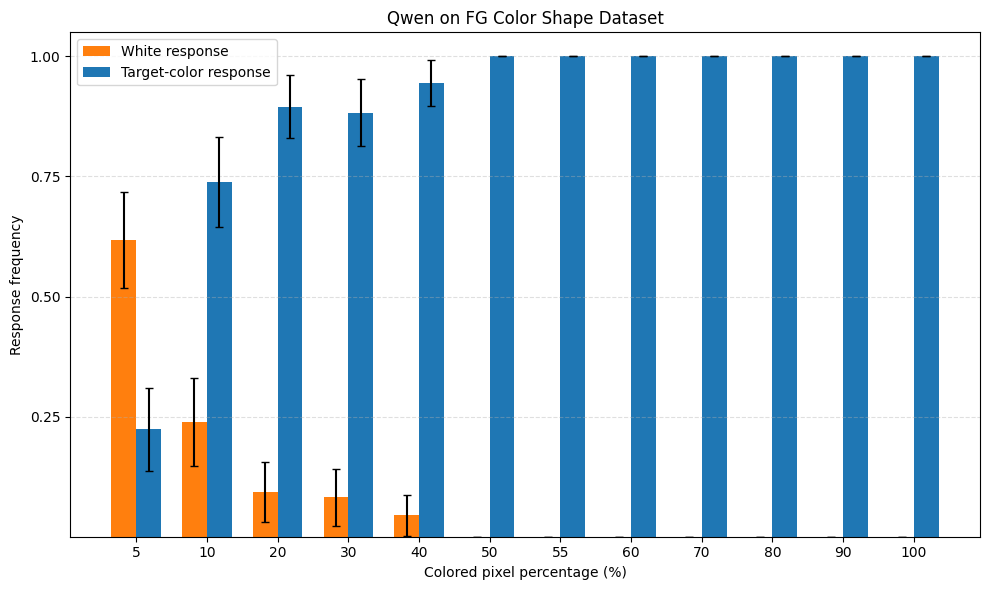

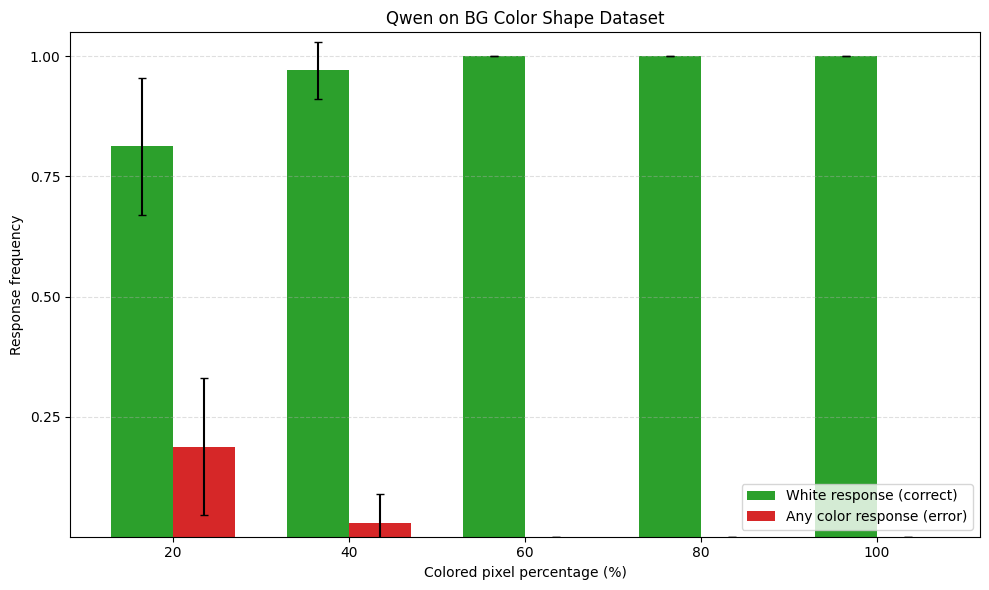

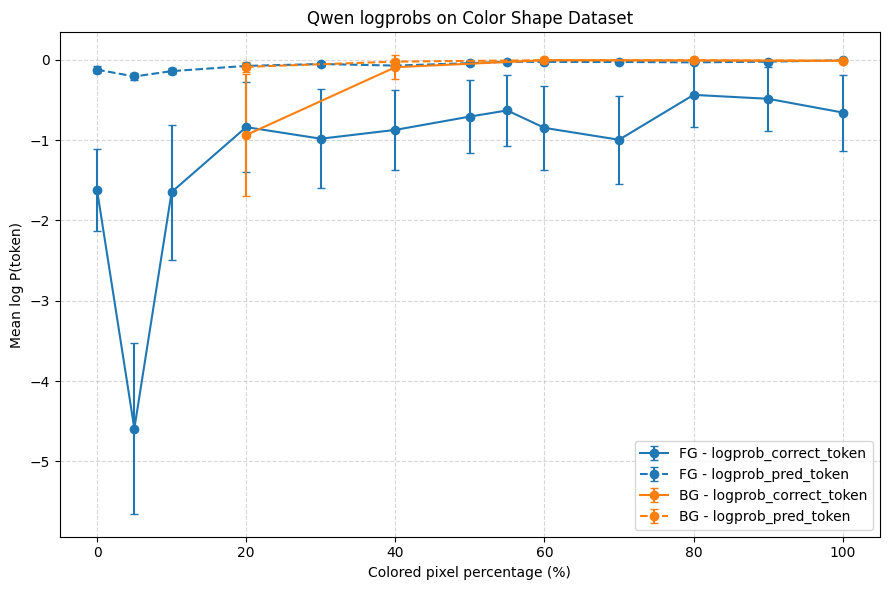

In [59]:
qwen_shape_pred_df = pd.read_csv(QWEN / f"evaluation_{qwen_model_name}_shapes.csv")
qwen_shape_pred_df["predicted_color"] = qwen_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
qwen_shape_pred_df = qwen_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(qwen_shape_pred_df)

plot_fg_response_frequencies_bar(qwen_shape_pred_df, title="Qwen on FG Color Shape Dataset", response_col="predicted_color")
plot_bg_response_frequencies_bar(qwen_shape_pred_df, title="Qwen on BG Color Shape Dataset", response_col="predicted_color")

plot_model_logprobs(
    qwen_shape_pred_df,
    title="Qwen logprobs on Color Shape Dataset"
)

## 3.4.2. Shape Dataset with Introspection Question (Qwen3-VL)

In [44]:
suffix = "shapes"
introsp_qwen_shape_pred_df = evaluate_vlm_on_stimuli(
    shape_df,
    backend="qwen",
    processor=qwen_processor,
    model=qwen_model,
    device=device,
    calibration_value=qwen_threshold,
    image_root=DATA
)

out_path = QWEN / f"introsp_evaluation_{qwen_model_name}_{suffix}.csv"
introsp_qwen_shape_pred_df.to_csv(out_path, index=False)

Evaluating stimuli: 100%|██████████| 1331/1331 [13:51<00:00,  1.60it/s]


,image_path,object,correct_answer,predicted_color,logprob_pred_token,logprob_correct_token,correct_in_top_k,calibration,calibration_threshold,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,variant_label,mode
0,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,yellow,yellow,-0.001458,-0.001458,True,50,50,shape,yellow,yellow,FG,60,FG 60% (seq),seq
1,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,purple,purple,-0.081318,-0.081318,True,50,50,shape,purple,purple,FG,55,FG 55% (seq),seq
2,/mnt/lustre/work/eickhoff/esx061/color-concept...,square,blue,blue,-0.038924,-0.038924,True,50,50,shape,blue,blue,FG,5,FG 5% (seq),seq
3,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,brown,brown,-0.023266,-0.023266,True,50,50,shape,brown,brown,FG,50,FG 50% (seq),seq
4,/mnt/lustre/work/eickhoff/esx061/color-concept...,pentagon,orange,orange,-0.081312,-0.081312,True,50,50,shape,orange,orange,FG,90,FG 90% (seq),seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,/mnt/lustre/work/eickhoff/esx061/color-concept...,circle,grey,grey,-0.065168,-7.127668,True,50,50,shape,grey,grey,FG,40,FG 40% (seq),seq
1327,/mnt/lustre/work/eickhoff/esx061/color-concept...,hexagon,brown,brown,-0.047143,-0.047143,True,50,50,shape,brown,brown,FG,70,FG 70% (seq),seq
1328,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.377229,-0.377229,True,50,50,shape,blue,white,FG,0,FG 0% (seq),seq
1329,/mnt/lustre/work/eickhoff/esx061/color-concept...,triangle,white,white,-0.043655,-0.043655,True,50,50,shape,red,white,BG,40,BG 40% (seq),seq


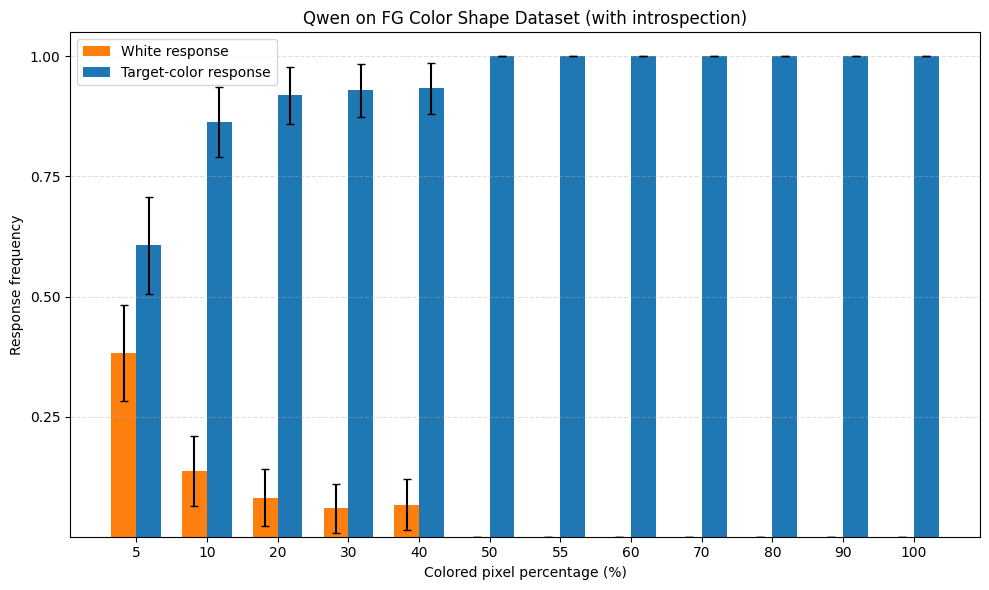

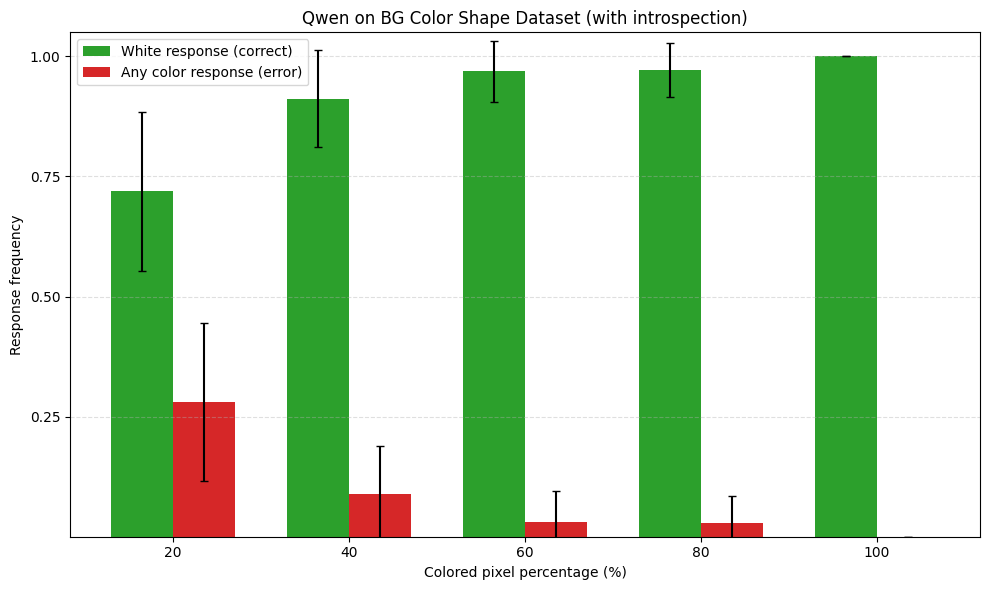

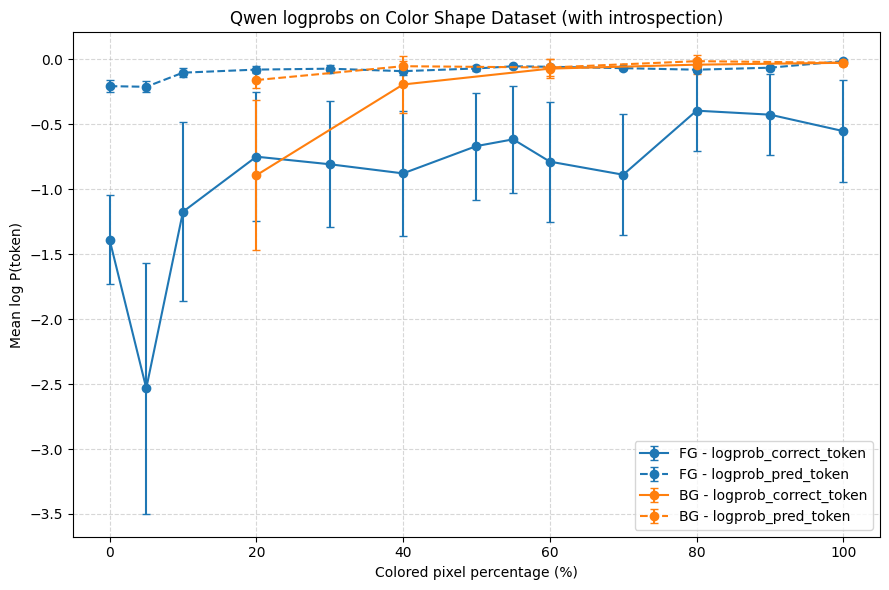

In [60]:
introsp_qwen_shape_pred_df = pd.read_csv(QWEN / f"introsp_evaluation_{qwen_model_name}_shapes.csv")
introsp_qwen_shape_pred_df["predicted_color"] = introsp_qwen_shape_pred_df["predicted_color"].apply(normalize_color_prediction)
introsp_qwen_shape_pred_df = introsp_qwen_shape_pred_df.merge(shape_df, on=["image_path", "object"])
display(introsp_qwen_shape_pred_df)

plot_fg_response_frequencies_bar(introsp_qwen_shape_pred_df, title="Qwen on FG Color Shape Dataset (with introspection)", response_col="predicted_color")
plot_bg_response_frequencies_bar(introsp_qwen_shape_pred_df, title="Qwen on BG Color Shape Dataset (with introspection)", response_col="predicted_color")

plot_model_logprobs(
    introsp_qwen_shape_pred_df,
    title="Qwen logprobs on Color Shape Dataset (with introspection)"
)